# weather CNN model

### checking the evironment

In [1]:
import pkg_resources
installed_packages = [pkg.key for pkg in pkg_resources.working_set]
print(installed_packages)

['certifi', 'pytz', 'pywin32', 'setuptools', 'pyzmq', 'flatbuffers', 'packaging', 'pip', 'libclang', 'pillow', 'ipython', 'jupyter-client', 'ipykernel', 'tornado', 'importlib-metadata', 'importlib-resources', 'psutil', 'traitlets', 'cachetools', 'jupyter-core', 'decorator', 'fonttools', 'rsa', 'typing-extensions', 'protobuf', 'zipp', 'h5py', 'matplotlib', 'markdown', 'idna', 'opt-einsum', 'oauthlib', 'threadpoolctl', 'prompt-toolkit', 'pyparsing', 'charset-normalizer', 'platformdirs', 'requests', 'google-auth', 'pygments', 'tensorboard', 'keras', 'tensorflow-cpu', 'tensorflow-estimator', 'tensorflow-intel', 'python-dateutil', 'werkzeug', 'asttokens', 'termcolor', 'markupsafe', 'grpcio', 'urllib3', 'numpy', 'six', 'wrapt', 'scipy', 'tensorboard-plugin-wit', 'debugpy', 'astunparse', 'nest-asyncio', 'pandas', 'kiwisolver', 'absl-py', 'requests-oauthlib', 'scikit-learn', 'executing', 'joblib', 'keras-preprocessing', 'contourpy', 'wheel', 'tensorflow-io-gcs-filesystem', 'jedi', 'seaborn', '

### importing packages

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import time
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## help functions

Creating network by number of layers.

In [56]:
def generateModelPerLayerNumber(numberOfLayers, numberOfFeatures, outdim=6):
    """
    generates a model with numOfLayers layers, with the first layer with 512 dimensions, and the last layer with 10, and the 
    rest are equally spread in between linearly. for example 5 layers will be 512, 387, 262, 137, 10
    """
    startdim = numberOfFeatures - 5
    model = Sequential()
    diff = (startdim - outdim) // (numberOfLayers - 1) # difference between each dimension
    
    model.add(Dense(numberOfFeatures-5, input_shape=(numberOfFeatures,), activation='relu'))
    
    for i in range (1, numberOfLayers - 1):
        model.add(Dense(512 - diff * i, 'relu'))
    
    model.add(Dense(outdim, activation='sigmoid'))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
    return model

function to plot confustion matrix

In [69]:
def plotConfusionMatrix(matrix):
    plt.subplots(figsize = (12,12))
    sns.set(font_scale = 1.4)
    sns.heatmap(matrix, annot = True, fmt = ".0f", annot_kws = {"size": 16}, cbar = False)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title('ConfusionMatrix')
    plt.show()

training model with different epochs and batchsize:

In [25]:
def dynamicTrainModel(trainData, trainLabels, epochs, batchSize, model):
    imagesDf = model.fit(
        trainData, trainLabels, 
        validation_data = None,
        epochs = epochs,
        batch_size = batchSize,
        verbose = 1)
    return imagesDf.history, model


testing model and creating graph for accuracy and loss per epoch

In [27]:
def testModel(fitData, title = "accuracy and loss per epoch"):
    fig, ax = plt.subplots(figsize = (6, 9))
    lossLine = ax.plot(fitData['loss'], label = 'loss', color = 'red')
    ax.set_ylabel('loss')
    ax2 = ax.twinx()
    accuracyLine = ax2.plot(fitData['accuracy'], label = 'accuracy', color = 'blue')
    ax2.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    
    lines = lossLine + accuracyLine

    ax.legend(lines, [line.get_label() for line in lines], loc = ("upper center"))
    plt.title(title)
    
    plt.show()


function that trains multiple models by layars, epochs and batches:

In [27]:
def trainModels(numberOfLayersToTest, epochsToTest, batchSizesToTest, trainData, trainLabels):
    fitModels = dict()
    histories = dict()
    for numberOfLayers in numberOfLayersToTest:
        for epochs in epochsToTest:
            for batchSize in batchSizesToTest:
                model = generateModelPerLayerNumber(numberOfLayers, trainData.shape[1])
                history, fitModel = dynamicTrainModel(trainData, trainLabels, epochs, batchSize, model)
                key = f'numberOfLayers is {numberOfLayers}. epochs is {epochs}. batchSize is {batchSize}'
                testModel(history, f'accuracy vs loss, {numberOfLayers} layers, {epochs} epochs, {batchSize} batchSize')
                fitModels[key] = fitModel
                histories[key] = history
    return histories, fitModels

## opening the data

In [3]:
data = pd.read_csv('hisotryWithRollingAverages.csv')

In [4]:
data.head()

Unnamed: 0            Date time  Minimum Temperature  Maximum Temperature  \
0           0  2023-02-01 00:00:00                 50.9                 50.9   
1           1  2023-02-01 01:00:00                 44.0                 44.0   
2           2  2023-02-01 02:00:00                 44.7                 44.7   
3           3  2023-02-01 03:00:00                 44.7                 44.7   
4           4  2023-02-01 04:00:00                 44.7                 44.7   

   Temperature  Dew Point  Relative Humidity  Heat Index  Wind Speed  \
0         50.9       49.1              93.53         NaN         7.0   
1         44.0       39.5              84.07         NaN        13.0   
2         44.7       39.9              82.97         NaN        10.1   
3         44.7       39.9              82.95         NaN        14.3   
4         44.7       39.9              82.97         NaN         9.8   

   Wind Gust  ...              Weather Type  Conditions     temp_c  Month  \
0        NaN  ...              Thunderstorm    Overcast  10.500000      2   
1        NaN  ...              Thunderstorm    Overcast   6.666667      2   
2        NaN  ...  Mist, Rain, Thunderstorm    Overcast   7.055556      2   
3        NaN  ...  Thunderstorm, Light Rain    Overcast   7.055556      2   
4        NaN  ...        Rain, Thunderstorm    Overcast   7.055556      2   

   Year  Temperature_Lag1  Temperature_Lag2 Precipitation_Lag1  \
0  2023               NaN               NaN                NaN   
1  2023              50.9               NaN                0.0   
2  2023              44.0              50.9                0.0   
3  2023              44.7              44.0                0.0   
4  2023              44.7              44.7                0.0   

  Precipitation_Lag2  temp_7d_rolling  
0                NaN              NaN  
1                NaN              NaN  
2                0.0              NaN  
3                0.0              NaN  
4                0.0              NaN  

[5 rows x 27 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439918 entries, 0 to 439917
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           439918 non-null  int64  
 1   Date time            439918 non-null  object 
 2   Minimum Temperature  421821 non-null  float64
 3   Maximum Temperature  421821 non-null  float64
 4   Temperature          421821 non-null  float64
 5   Dew Point            421543 non-null  float64
 6   Relative Humidity    421543 non-null  float64
 7   Heat Index           60366 non-null   float64
 8   Wind Speed           421543 non-null  float64
 9   Wind Gust            1026 non-null    float64
 10  Wind Direction       397295 non-null  float64
 11  Wind Chill           40460 non-null   float64
 12  Precipitation        439918 non-null  float64
 13  Snow Depth           196268 non-null  float64
 14  Visibility           421334 non-null  float64
 15  Cloud Cover      

# testing basic feature

### sampling data for testing

In [6]:
test = data.head(1000).copy()
test

Unnamed: 0            Date time  Minimum Temperature  \
0             0  2023-02-01 00:00:00                 50.9   
1             1  2023-02-01 01:00:00                 44.0   
2             2  2023-02-01 02:00:00                 44.7   
3             3  2023-02-01 03:00:00                 44.7   
4             4  2023-02-01 04:00:00                 44.7   
..          ...                  ...                  ...   
995          81  2022-12-28 09:00:00                 51.0   
996          82  2022-12-28 10:00:00                 52.1   
997          83  2022-12-28 11:00:00                 53.9   
998          84  2022-12-28 12:00:00                 53.9   
999          85  2022-12-28 13:00:00                 63.9   

     Maximum Temperature  Temperature  Dew Point  Relative Humidity  \
0                   50.9         50.9       49.1              93.53   
1                   44.0         44.0       39.5              84.07   
2                   44.7         44.7       39.9              82.97   
3                   44.7         44.7       39.9              82.95   
4                   44.7         44.7       39.9              82.97   
..                   ...          ...        ...                ...   
995                 51.0         51.0       42.9              73.70   
996                 52.1         52.1       41.7              67.45   
997                 53.9         53.9       43.1              66.72   
998                 53.9         53.9       44.3              69.96   
999                 63.9         63.9       48.0              56.35   

     Heat Index  Wind Speed  Wind Gust  ...              Weather Type  \
0           NaN         7.0        NaN  ...              Thunderstorm   
1           NaN        13.0        NaN  ...              Thunderstorm   
2           NaN        10.1        NaN  ...  Mist, Rain, Thunderstorm   
3           NaN        14.3        NaN  ...  Thunderstorm, Light Rain   
4           NaN         9.8        NaN  ...        Rain, Thunderstorm   
..          ...         ...        ...  ...                       ...   
995         NaN         2.7        NaN  ...                      Mist   
996         NaN         2.3        NaN  ...                       NaN   
997         NaN         4.7        NaN  ...             Smoke Or Haze   
998         NaN         2.9        NaN  ...                       NaN   
999         NaN         3.4        NaN  ...                       NaN   

           Conditions     temp_c  Month  Year  Temperature_Lag1  \
0            Overcast  10.500000      2  2023               NaN   
1            Overcast   6.666667      2  2023              50.9   
2            Overcast   7.055556      2  2023              44.0   
3            Overcast   7.055556      2  2023              44.7   
4            Overcast   7.055556      2  2023              44.7   
..                ...        ...    ...   ...               ...   
995             Clear  10.555556     12  2022              49.4   
996             Clear  11.166667     12  2022              51.0   
997             Clear  12.166667     12  2022              52.1   
998  Partially cloudy  12.166667     12  2022              53.9   
999  Partially cloudy  17.722222     12  2022              53.9   

     Temperature_Lag2 Precipitation_Lag1 Precipitation_Lag2  temp_7d_rolling  
0                 NaN                NaN                NaN              NaN  
1                 NaN                0.0                NaN              NaN  
2                50.9                0.0                0.0              NaN  
3                44.0                0.0                0.0              NaN  
4                44.7                0.0                0.0              NaN  
..                ...                ...                ...              ...  
995              45.6                0.0                0.0        50.461905  
996              49.4                0.0                0.0        50.372024  
997              51.0     

In [7]:
Conditions_one_hot = pd.get_dummies(test.Conditions)
Conditions_one_hot

Clear  Overcast  Partially cloudy  Rain  Rain, Overcast  \
0        0         1                 0     0               0   
1        0         1                 0     0               0   
2        0         1                 0     0               0   
3        0         1                 0     0               0   
4        0         1                 0     0               0   
..     ...       ...               ...   ...             ...   
995      1         0                 0     0               0   
996      1         0                 0     0               0   
997      1         0                 0     0               0   
998      0         0                 1     0               0   
999      0         0                 1     0               0   

     Rain, Partially cloudy  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
..                      ...  
995                       0  
996                       0  
997                       0  
998                       0  
999                       0  

[1000 rows x 6 columns]

### testing basic network

In [8]:
x_vectors = test.drop('Conditions', axis=1)

In [9]:
weather_type = pd.get_dummies(x_vectors['Weather Type'])
weather_type

Drizzle  Drizzle, Rain  Drizzle, Smoke Or Haze  \
0          0              0                       0   
1          0              0                       0   
2          0              0                       0   
3          0              0                       0   
4          0              0                       0   
..       ...            ...                     ...   
995        0              0                       0   
996        0              0                       0   
997        0              0                       0   
998        0              0                       0   
999        0              0                       0   

     Drizzle, Thunderstorm Without Precipitation  Hail Showers  \
0                                              0             0   
1                                              0             0   
2                                              0             0   
3                                              0             0   
4                                              0             0   
..                                           ...           ...   
995                                            0             0   
996                                            0             0   
997                                            0             0   
998                                            0             0   
999                                            0             0   

     Hail Showers, Rain, Light Rain  Heavy Drizzle/Rain  \
0                                 0                   0   
1                                 0                   0   
2                                 0                   0   
3                                 0                   0   
4                                 0                   0   
..                              ...                 ...   
995                               0                   0   
996                               0                   0   
997                               0                   0   
998                               0                   0   
999                               0                   0   

     Heavy Rain, Sky Coverage Increasing  Light Drizzle  \
0                                      0              0   
1                                      0              0   
2                                      0              0   
3                                      0              0   
4                                      0              0   
..                                   ...            ...   
995                                    0              0   
996                                    0              0   
997                                    0              0   
998                                    0              0   
999                                    0              0   

     Light Drizzle, Light Rain  ...  \
0                            0  ...   
1                            0  ...   
2                            0  ...   
3                            0  ...   
4                            0  ...   
..                         ...  ...   
995                          0  ...   
996                          0  ...   
997                          0  ...   
998                          0  ...   
999                          0  ...   

     Thunderstorm Without Precipitation, Rain Showers, Heavy Rain  \
0                                                    0              
1                                                    0              
2                                                    0              
3                                                    0              
4                                                    0              
..                                                 ...              
995                                                  0              
996                                                  0              
997                                        

In [11]:
model = generateModelPerLayerNumber(3,79)

In [12]:
model.fit(weather_type, Conditions_one_hot, validation_split=0.2, epochs=10, verbose=1)

Epoch 1/10
25/25 [==============================] - 1s 22ms/step - loss: 0.1940 - accuracy: 0.4075 - val_loss: 0.1331 - val_accuracy: 0.6250
Epoch 2/10
25/25 [==============================] - 0s 12ms/step - loss: 0.1092 - accuracy: 0.5288 - val_loss: 0.1063 - val_accuracy: 0.6250
Epoch 3/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0974 - accuracy: 0.5087 - val_loss: 0.1056 - val_accuracy: 0.6250
Epoch 4/10
25/25 [==============================] - 0s 12ms/step - loss: 0.0941 - accuracy: 0.5337 - val_loss: 0.1170 - val_accuracy: 0.2500
Epoch 5/10
25/25 [==============================] - 0s 12ms/step - loss: 0.0900 - accuracy: 0.5825 - val_loss: 0.1032 - val_accuracy: 0.3700
Epoch 6/10
25/25 [==============================] - 0s 12ms/step - loss: 0.0884 - accuracy: 0.5788 - val_loss: 0.1075 - val_accuracy: 0.3600
Epoch 7/10
25/25 [==============================] - 0s 12ms/step - loss: 0.0874 - accuracy: 0.5962 - val_loss: 0.1053 - val_accuracy: 0.3750
Epoch 8/10
25

## creating full model on test sample

In [13]:
labels = tf.convert_to_tensor(Conditions_one_hot, dtype = tf.float64)

### fixing the date time objects

In [14]:
test['Date time'] = pd.to_datetime(test['Date time'])
test['Date time'] = test['Date time'].apply(lambda x: x.timestamp())
test['Date time']

0      1.675210e+09
1      1.675213e+09
2      1.675217e+09
3      1.675220e+09
4      1.675224e+09
           ...     
995    1.672218e+09
996    1.672222e+09
997    1.672225e+09
998    1.672229e+09
999    1.672232e+09
Name: Date time, Length: 1000, dtype: float64

### fixing the Weather Type object
instead of one hot encoding we did it manually to decrease the number of features.

In [15]:
test['Weather Type']

0                  Thunderstorm
1                  Thunderstorm
2      Mist, Rain, Thunderstorm
3      Thunderstorm, Light Rain
4            Rain, Thunderstorm
                 ...           
995                        Mist
996                         NaN
997               Smoke Or Haze
998                         NaN
999                         NaN
Name: Weather Type, Length: 1000, dtype: object

In [16]:
test['Weather Type'] = test['Weather Type'].str.split(',')
test['Weather Type']

0                    [Thunderstorm]
1                    [Thunderstorm]
2      [Mist,  Rain,  Thunderstorm]
3       [Thunderstorm,  Light Rain]
4             [Rain,  Thunderstorm]
                   ...             
995                          [Mist]
996                             NaN
997                 [Smoke Or Haze]
998                             NaN
999                             NaN
Name: Weather Type, Length: 1000, dtype: object

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1000 non-null   int64  
 1   Date time            1000 non-null   float64
 2   Minimum Temperature  1000 non-null   float64
 3   Maximum Temperature  1000 non-null   float64
 4   Temperature          1000 non-null   float64
 5   Dew Point            1000 non-null   float64
 6   Relative Humidity    1000 non-null   float64
 7   Heat Index           0 non-null      float64
 8   Wind Speed           1000 non-null   float64
 9   Wind Gust            16 non-null     float64
 10  Wind Direction       980 non-null    float64
 11  Wind Chill           447 non-null    float64
 12  Precipitation        1000 non-null   float64
 13  Snow Depth           0 non-null      float64
 14  Visibility           1000 non-null   float64
 15  Cloud Cover          980 non-null    fl

In [18]:
a = test['Weather Type'].to_frame()
type(a['Weather Type'][1])

list

In [19]:
df = test['Weather Type'].to_frame()
df['Weather Type'] = df['Weather Type'].apply(lambda d: d if isinstance(d, list) else [])
mlb = MultiLabelBinarizer()
df_transformed = pd.DataFrame(mlb.fit_transform(df['Weather Type']), columns=mlb.classes_, index=df.index)
df_transformed.columns

Index([' Fog', ' Heavy Drizzle/Rain', ' Heavy Rain', ' Light Drizzle',
       ' Light Drizzle/Rain', ' Light Freezing Rain', ' Light Rain', ' Mist',
       ' Rain', ' Rain Showers', ' Sky Coverage Decreasing',
       ' Sky Coverage Increasing', ' Sky Unchanged', ' Smoke Or Haze', ' Snow',
       ' Thunderstorm', ' Thunderstorm Without Precipitation', 'Drizzle',
       'Hail Showers', 'Heavy Drizzle/Rain', 'Heavy Rain', 'Light Drizzle',
       'Light Drizzle/Rain', 'Light Rain', 'Lightning Without Thunder', 'Mist',
       'Rain', 'Rain Showers', 'Sky Coverage Decreasing',
       'Sky Coverage Increasing', 'Smoke Or Haze', 'Snow And Rain Showers',
       'Thunderstorm', 'Thunderstorm Without Precipitation'],
      dtype='object')

In [20]:
df_transformed

Fog   Heavy Drizzle/Rain   Heavy Rain   Light Drizzle  \
0       0                    0            0               0   
1       0                    0            0               0   
2       0                    0            0               0   
3       0                    0            0               0   
4       0                    0            0               0   
..    ...                  ...          ...             ...   
995     0                    0            0               0   
996     0                    0            0               0   
997     0                    0            0               0   
998     0                    0            0               0   
999     0                    0            0               0   

      Light Drizzle/Rain   Light Freezing Rain   Light Rain   Mist   Rain  \
0                      0                     0            0      0      0   
1                      0                     0            0      0      0   
2                      0                     0            0      0      1   
3                      0                     0            1      0      0   
4                      0                     0            0      0      0   
..                   ...                   ...          ...    ...    ...   
995                    0                     0            0      0      0   
996                    0                     0            0      0      0   
997                    0                     0            0      0      0   
998                    0                     0            0      0      0   
999                    0                     0            0      0      0   

      Rain Showers  ...  Lightning Without Thunder  Mist  Rain  Rain Showers  \
0                0  ...                          0     0     0             0   
1                0  ...                          0     0     0             0   
2                0  ...                          0     1     0             0   
3                0  ...                          0     0     0             0   
4                0  ...                          0     0     1             0   
..             ...  ...                        ...   ...   ...           ...   
995              0  ...                          0     1     0             0   
996              0  ...                          0     0     0             0   
997              0  ...                          0     0     0             0   
998              0  ...                          0     0     0             0   
999              0  ...                          0     0     0             0   

     Sky Coverage Decreasing  Sky Coverage Increasing  Smoke Or Haze  \
0                          0                        0              0   
1                          0                        0              0   
2                          0                        0              0   
3                          0                        0              0   
4                          0                        0              0   
..                       ...                      ...            ...   
995                        0                        0              0   
996                        0                        0              0   
997                        0                        0              1   
998                        0                        0              0   
999                        0                        0              0   

     Snow And Rain Showers  Thunderstorm  Thunderstorm Without Precipitation  
0                        0             1                                   0  
1                        0             1                                   0  
2                        0             0                                   0  
3                        0             1                                   0  
4                        0             0                                   0  
..                     .

### creating feature vector.
combining the new weather types features and droping the y label.

In [21]:
x_vector = pd.concat((test.drop(['Weather Type', 'Conditions'], axis=1),df_transformed), axis=1)
x_vector

Unnamed: 0     Date time  Minimum Temperature  Maximum Temperature  \
0             0  1.675210e+09                 50.9                 50.9   
1             1  1.675213e+09                 44.0                 44.0   
2             2  1.675217e+09                 44.7                 44.7   
3             3  1.675220e+09                 44.7                 44.7   
4             4  1.675224e+09                 44.7                 44.7   
..          ...           ...                  ...                  ...   
995          81  1.672218e+09                 51.0                 51.0   
996          82  1.672222e+09                 52.1                 52.1   
997          83  1.672225e+09                 53.9                 53.9   
998          84  1.672229e+09                 53.9                 53.9   
999          85  1.672232e+09                 63.9                 63.9   

     Temperature  Dew Point  Relative Humidity  Heat Index  Wind Speed  \
0           50.9       49.1              93.53         NaN         7.0   
1           44.0       39.5              84.07         NaN        13.0   
2           44.7       39.9              82.97         NaN        10.1   
3           44.7       39.9              82.95         NaN        14.3   
4           44.7       39.9              82.97         NaN         9.8   
..           ...        ...                ...         ...         ...   
995         51.0       42.9              73.70         NaN         2.7   
996         52.1       41.7              67.45         NaN         2.3   
997         53.9       43.1              66.72         NaN         4.7   
998         53.9       44.3              69.96         NaN         2.9   
999         63.9       48.0              56.35         NaN         3.4   

     Wind Gust  ...  Lightning Without Thunder  Mist  Rain  Rain Showers  \
0          NaN  ...                          0     0     0             0   
1          NaN  ...                          0     0     0             0   
2          NaN  ...                          0     1     0             0   
3          NaN  ...                          0     0     0             0   
4          NaN  ...                          0     0     1             0   
..         ...  ...                        ...   ...   ...           ...   
995        NaN  ...                          0     1     0             0   
996        NaN  ...                          0     0     0             0   
997        NaN  ...                          0     0     0             0   
998        NaN  ...                          0     0     0             0   
999        NaN  ...                          0     0     0             0   

     Sky Coverage Decreasing  Sky Coverage Increasing  Smoke Or Haze  \
0                          0                        0              0   
1                          0                        0              0   
2                          0                        0              0   
3                          0                        0              0   
4                          0                        0              0   
..                       ...                      ...            ...   
995                        0                        0              0   
996                        0                        0              0   
997                        0                        0              1   
998                        0                        0              0   
999                        0                        0              0   

     Snow And Rain Showers  Thunderstorm  Thunderstorm Without Precipitation  
0                        0             1                                   0  
1                        0             1                                   0  
2                        0             0                                   0  
3                        0             1                                   0  
4                        0             0  

In [22]:
x_vector = tf.convert_to_tensor(x_vector, dtype = tf.float64)

In [23]:
numberOfFeatures = x_vector.shape[1]
numberOfFeatures

59

### running a model for testing

In [24]:
model2 = generateModelPerLayerNumber(3, numberOfFeatures)
model2.fit(x_vector, labels, validation_split=0.2, epochs=10)

Epoch 1/10
25/25 [==============================] - 1s 19ms/step - loss: 0.2481 - accuracy: 0.4663 - val_loss: 0.2464 - val_accuracy: 0.0800
Epoch 2/10
25/25 [==============================] - 0s 12ms/step - loss: 0.2441 - accuracy: 0.4663 - val_loss: 0.2426 - val_accuracy: 0.0800
Epoch 3/10
25/25 [==============================] - 0s 12ms/step - loss: 0.2402 - accuracy: 0.4663 - val_loss: 0.2392 - val_accuracy: 0.0800
Epoch 4/10
25/25 [==============================] - 0s 13ms/step - loss: 0.2364 - accuracy: 0.4663 - val_loss: 0.2356 - val_accuracy: 0.0800
Epoch 5/10
25/25 [==============================] - 0s 14ms/step - loss: 0.2327 - accuracy: 0.4663 - val_loss: 0.2323 - val_accuracy: 0.0800
Epoch 6/10
25/25 [==============================] - 0s 16ms/step - loss: 0.2290 - accuracy: 0.4663 - val_loss: 0.2290 - val_accuracy: 0.0800
Epoch 7/10
25/25 [==============================] - 0s 15ms/step - loss: 0.2255 - accuracy: 0.4663 - val_loss: 0.2259 - val_accuracy: 0.0800
Epoch 8/10
25

### testing different model configurations.

Epoch 1/10
20/20 [==============================] - 1s 14ms/step - loss: 0.2485 - accuracy: 0.4590
Epoch 2/10
20/20 [==============================] - 0s 16ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/10
20/20 [==============================] - 0s 15ms/step - loss: 0.2390 - accuracy: 0.4750
Epoch 5/10
20/20 [==============================] - 0s 19ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/10
20/20 [==============================] - 1s 26ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/10
20/20 [==============================] - 0s 14ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/10
20/20 [==============================] - 0s 10ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/10
20/20 [==============================] - 0s 10ms/step - loss: 0.2216 - accuracy: 0.4750


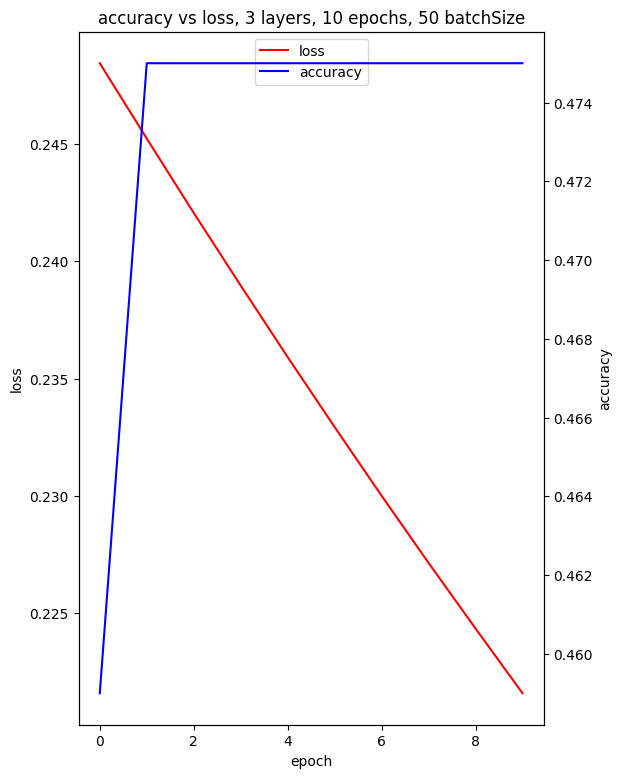

Epoch 1/10
10/10 [==============================] - 1s 19ms/step - loss: 0.2493 - accuracy: 0.4500
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/10
10/10 [==============================] - 0s 10ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/10
10/10 [==============================] - 0s 10ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/10
10/10 [==============================] - 0s 15ms/step - loss: 0.2351 - accuracy: 0.4750


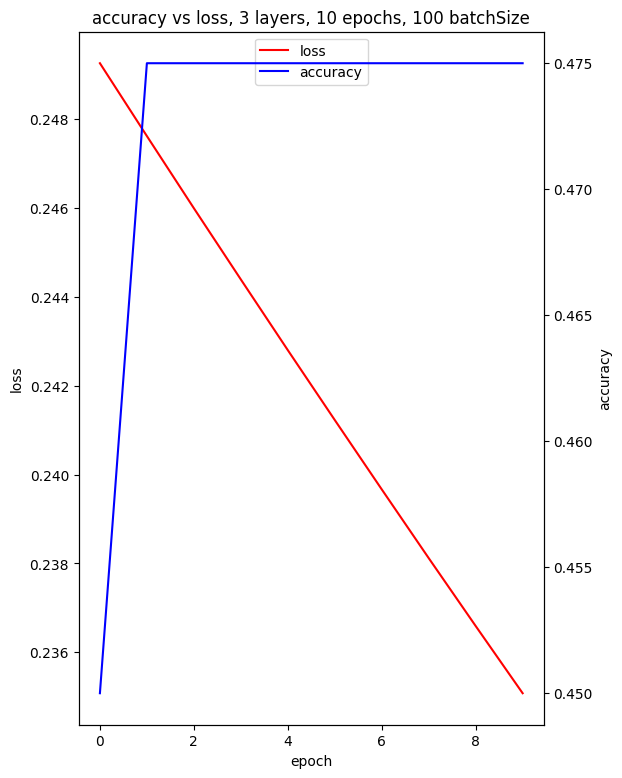

Epoch 1/10
7/7 [==============================] - 1s 10ms/step - loss: 0.2495 - accuracy: 0.4530
Epoch 2/10
7/7 [==============================] - 0s 11ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/10
7/7 [==============================] - 0s 10ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/10
7/7 [==============================] - 0s 10ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/10
7/7 [==============================] - 0s 9ms/step - loss: 0.2439 - accuracy: 0.4750
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/10
7/7 [==============================] - 0s 10ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/10
7/7 [==============================] - 0s 9ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/10
7/7 [==============================] - 0s 10ms/step - loss: 0.2394 - accuracy: 0.4750


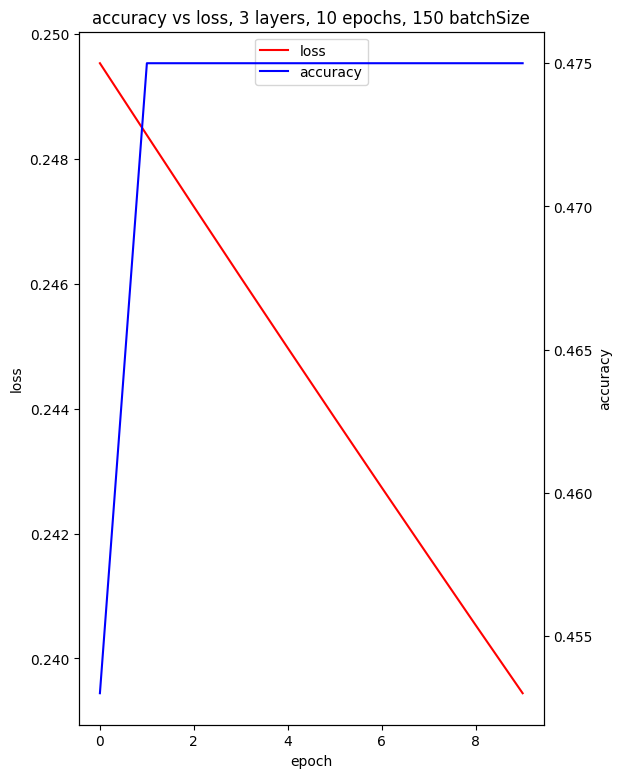

Epoch 1/20
20/20 [==============================] - 0s 9ms/step - loss: 0.2484 - accuracy: 0.4620
Epoch 2/20
20/20 [==============================] - 0s 9ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.2420 - accuracy: 0.4750
Epoch 4/20
20/20 [==============================] - 0s 8ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/20
20/20 [==============================] - 0s 9ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/20
20/20 [==============================] - 0s 9ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/20
20/20 [==============================] - 0s 10ms/step - loss: 0.2216 - accuracy: 0.4750
Epoch 11/20
20/20 

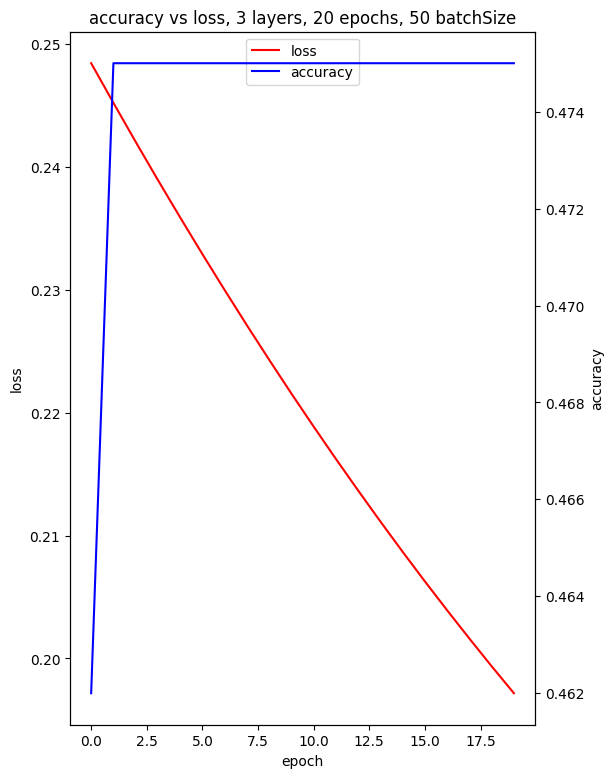

Epoch 1/20
10/10 [==============================] - 0s 10ms/step - loss: 0.2493 - accuracy: 0.4470
Epoch 2/20
10/10 [==============================] - 0s 10ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/20
10/10 [==============================] - 0s 10ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/20
10/10 [==============================] - 0s 10ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/20
10/10 [==============================] - 0s 10ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/20
10/10 [==============================] - 0s 10ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/20
10/10 [==============================] - 0s 10ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/20
10/10 [==============================] - 0s 10ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/20
10/10 [==============================] - 0s 10ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/20
10/10 [==============================] - 0s 9ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/2

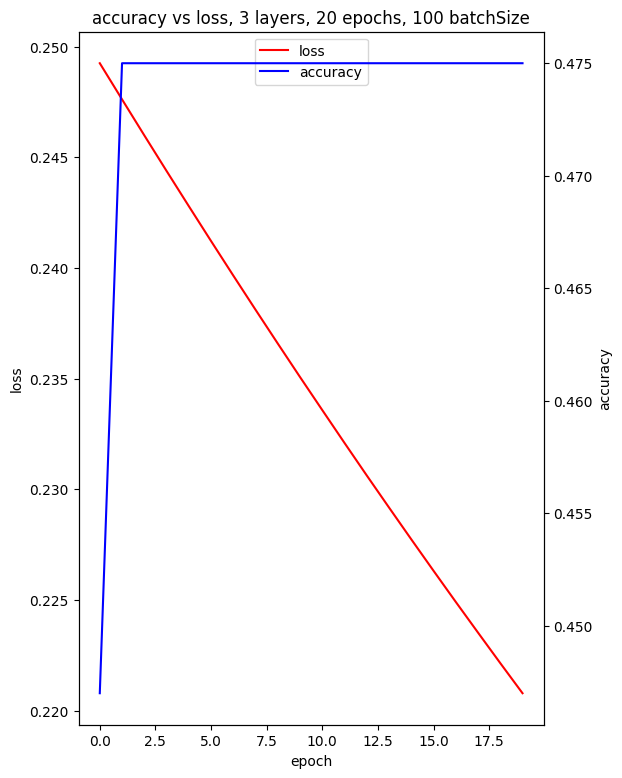

Epoch 1/20
7/7 [==============================] - 0s 10ms/step - loss: 0.2495 - accuracy: 0.4360
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/20
7/7 [==============================] - 0s 10ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/20
7/7 [==============================] - 0s 10ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/20
7/7 [==============================] - 0s 11ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/20
7/7 [==============================] - 0s 11ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/20
7/7 [=================

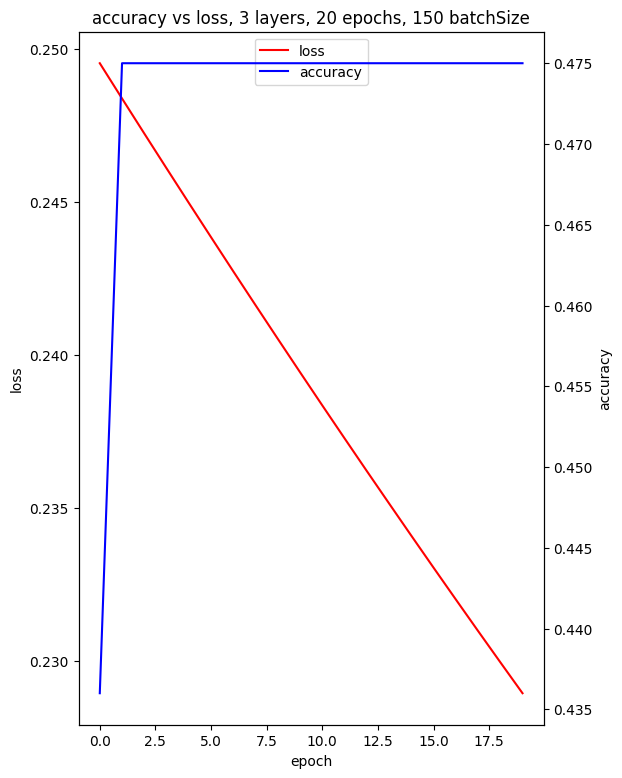

Epoch 1/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2484 - accuracy: 0.4700
Epoch 2/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2420 - accuracy: 0.4750
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2215 - accuracy: 0.4750
Epoch 11/30
20/20 [

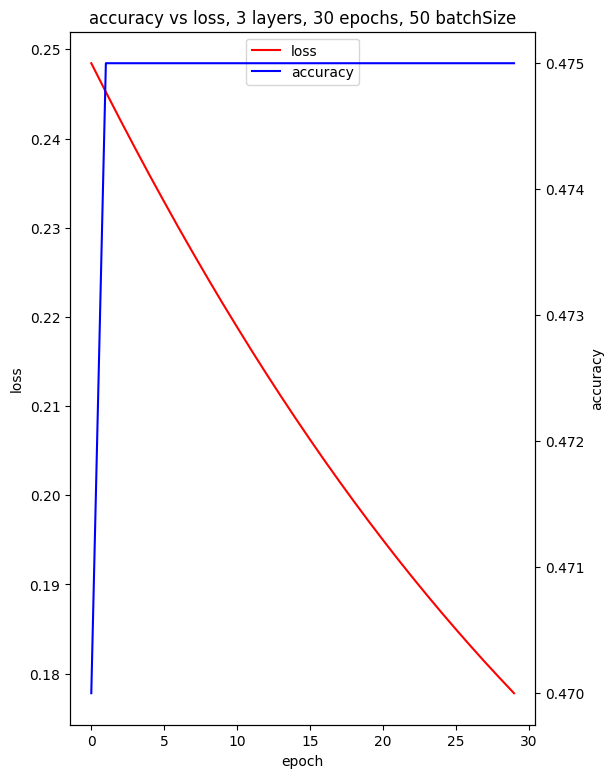

Epoch 1/30
10/10 [==============================] - 0s 10ms/step - loss: 0.2493 - accuracy: 0.4600
Epoch 2/30
10/10 [==============================] - 0s 10ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/30
10/10 [==============================] - 0s 10ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/30
10/10 [==============================] - 0s 10ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/30
10/10 [==============================] - 0s 10ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/30
10/10 [==============================] - 0s 11ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/30
10/10 [==============================] - 0s 9ms/step - loss: 0.2396 - accuracy: 0.4750
Epoch 8/30
10/10 [==============================] - 0s 10ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/30
10/10 [==============================] - 0s 10ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/30
10/10 [==============================] - 0s 10ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/3

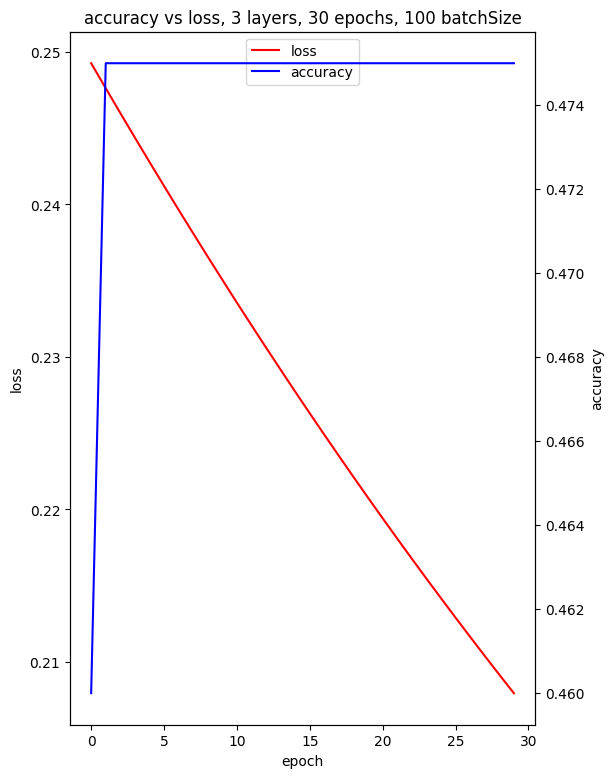

Epoch 1/30
7/7 [==============================] - 1s 11ms/step - loss: 0.2495 - accuracy: 0.4620
Epoch 2/30
7/7 [==============================] - 0s 10ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/30
7/7 [==============================] - 0s 10ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/30
7/7 [==============================] - 0s 10ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/30
7/7 [==============================] - 0s 10ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/30
7/7 [==============================] - 0s 9ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/30
7/7 [==============================] - 0s 8ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/30
7/7 [==============================] - 0s 10ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/30
7/7 [==============================] - 0s 10ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/30
7/7 [==============================] - 0s 9ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/30
7/7 [===============

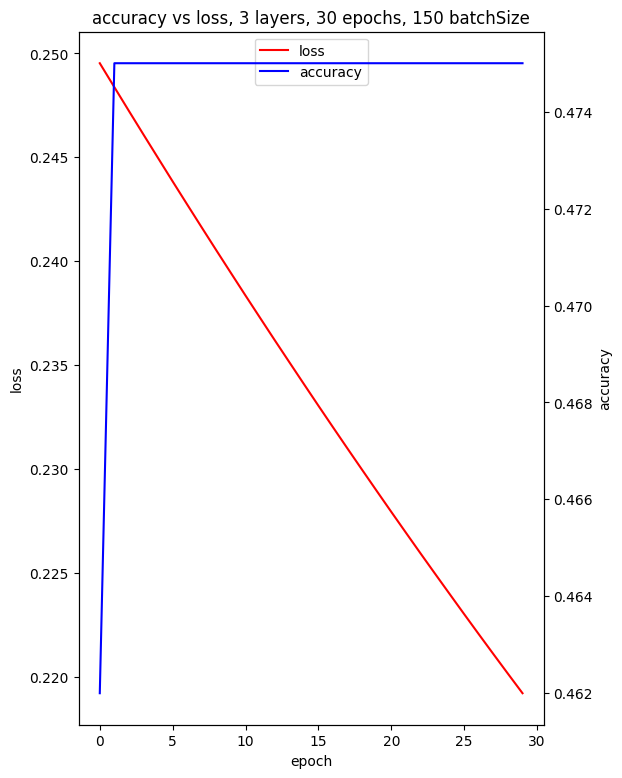

Epoch 1/10
20/20 [==============================] - 1s 13ms/step - loss: 0.2484 - accuracy: 0.4710
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.2420 - accuracy: 0.4750
Epoch 4/10
20/20 [==============================] - 0s 12ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/10
20/20 [==============================] - 0s 12ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/10
20/20 [==============================] - 0s 12ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/10
20/20 [==============================] - 0s 12ms/step - loss: 0.2215 - accuracy: 0.4750


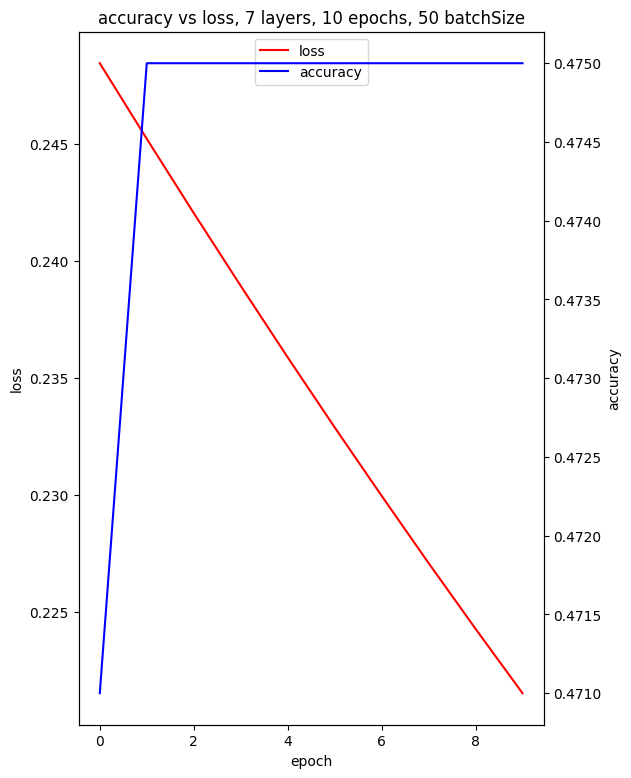

Epoch 1/10
10/10 [==============================] - 1s 14ms/step - loss: 0.2493 - accuracy: 0.4600
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/10
10/10 [==============================] - 0s 12ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/10
10/10 [==============================] - 0s 12ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/10
10/10 [==============================] - 0s 13ms/step - loss: 0.2351 - accuracy: 0.4750


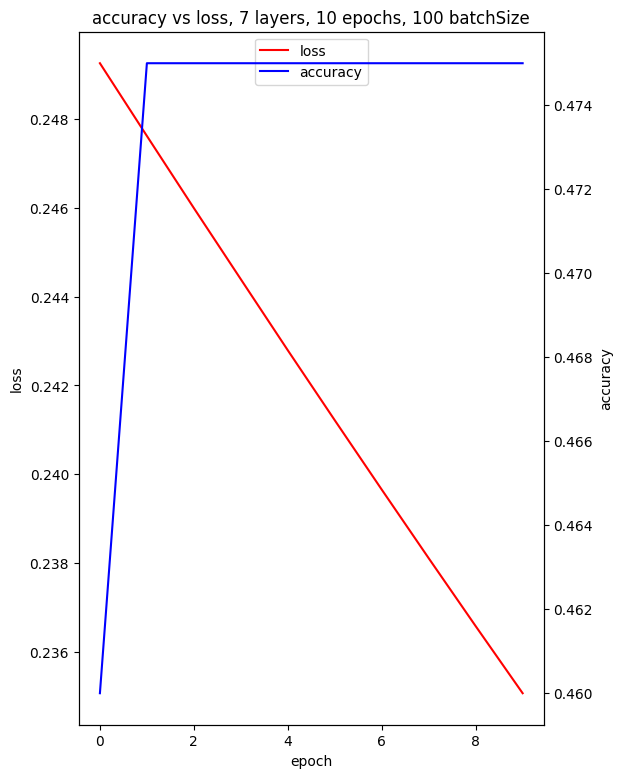

Epoch 1/10
7/7 [==============================] - 1s 16ms/step - loss: 0.2495 - accuracy: 0.4680
Epoch 2/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/10
7/7 [==============================] - 0s 14ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/10
7/7 [==============================] - 0s 14ms/step - loss: 0.2394 - accuracy: 0.4750


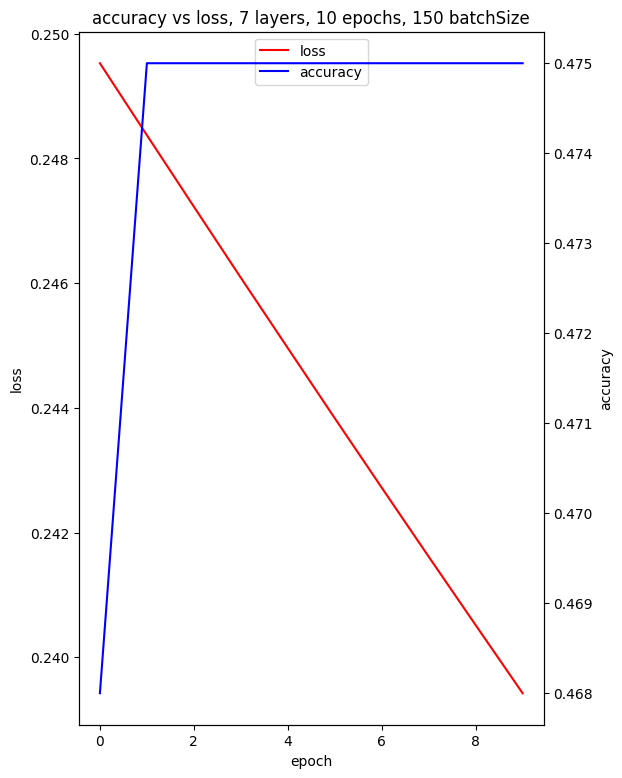

Epoch 1/20
20/20 [==============================] - 1s 19ms/step - loss: 0.2485 - accuracy: 0.4080
Epoch 2/20
20/20 [==============================] - 0s 12ms/step - loss: 0.2453 - accuracy: 0.4750
Epoch 3/20
20/20 [==============================] - 0s 11ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/20
20/20 [==============================] - 0s 12ms/step - loss: 0.2390 - accuracy: 0.4750
Epoch 5/20
20/20 [==============================] - 0s 12ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/20
20/20 [==============================] - 0s 12ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/20
20/20 [==============================] - 0s 12ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/20
20/20 [==============================] - 0s 12ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/20
20/20 [==============================] - 0s 12ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/20
20/20 [==============================] - 0s 12ms/step - loss: 0.2216 - accuracy: 0.4750
Epoch 11/

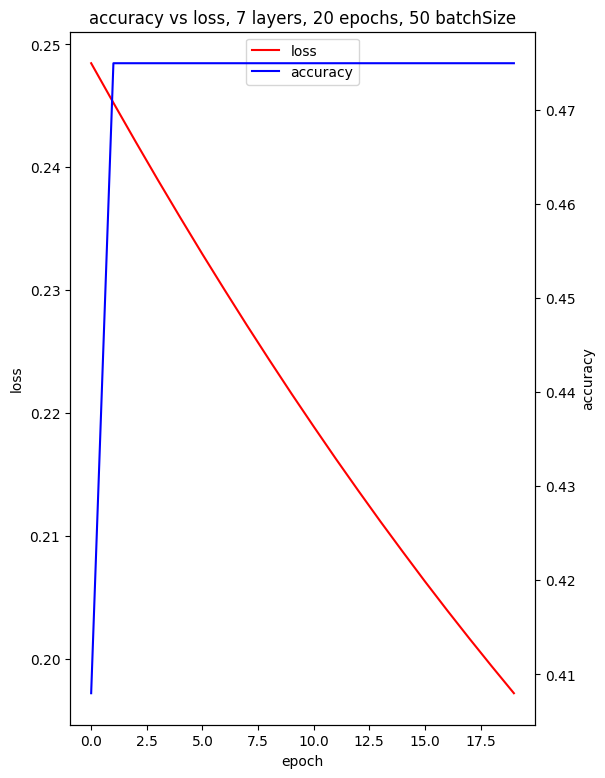

Epoch 1/20
10/10 [==============================] - 1s 14ms/step - loss: 0.2493 - accuracy: 0.4670
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/20
10/10 [==============================] - 0s 14ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/20
10/10 [==============================] - 0s 12ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/20
10/10 [==============================] - 0s 12ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/20
10/10 [==============================] - 0s 13ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/

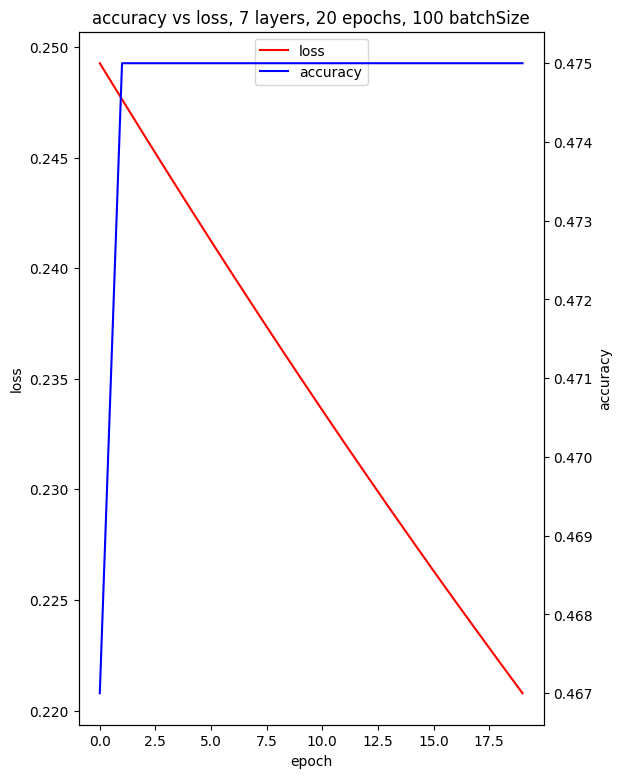

Epoch 1/20
7/7 [==============================] - 1s 15ms/step - loss: 0.2495 - accuracy: 0.4470
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2439 - accuracy: 0.4750
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2395 - accuracy: 0.4750
Epoch 11/20
7/7 [============

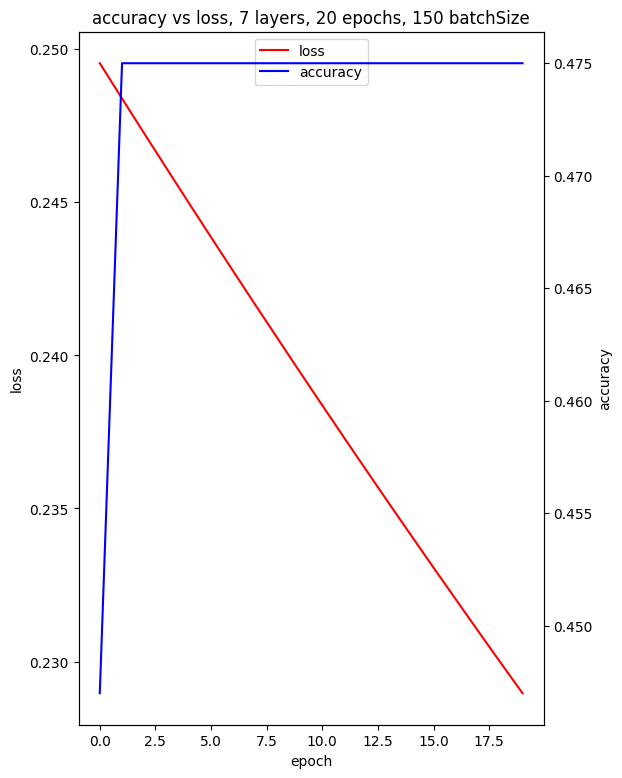

Epoch 1/30
20/20 [==============================] - 1s 13ms/step - loss: 0.2485 - accuracy: 0.4520
Epoch 2/30
20/20 [==============================] - 0s 13ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/30
20/20 [==============================] - 0s 12ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/30
20/20 [==============================] - 0s 12ms/step - loss: 0.2390 - accuracy: 0.4750
Epoch 5/30
20/20 [==============================] - 0s 12ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/30
20/20 [==============================] - 0s 12ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/30
20/20 [==============================] - 0s 12ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/30
20/20 [==============================] - 0s 12ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/30
20/20 [==============================] - 0s 11ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/30
20/20 [==============================] - 0s 12ms/step - loss: 0.2216 - accuracy: 0.4750
Epoch 11/

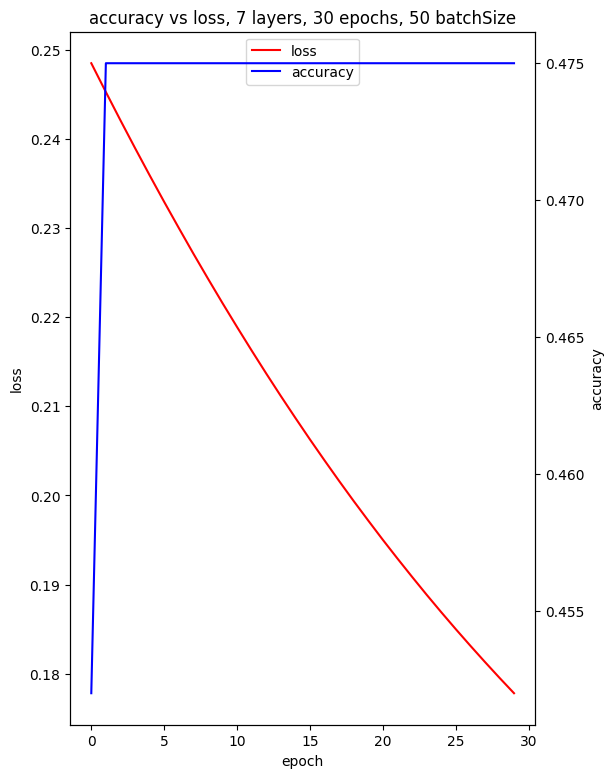

Epoch 1/30
10/10 [==============================] - 1s 14ms/step - loss: 0.2493 - accuracy: 0.4670
Epoch 2/30
10/10 [==============================] - 0s 13ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/30
10/10 [==============================] - 0s 13ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/30
10/10 [==============================] - 0s 13ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/30
10/10 [==============================] - 0s 12ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/30
10/10 [==============================] - 0s 12ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/30
10/10 [==============================] - 0s 13ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/30
10/10 [==============================] - 0s 13ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/

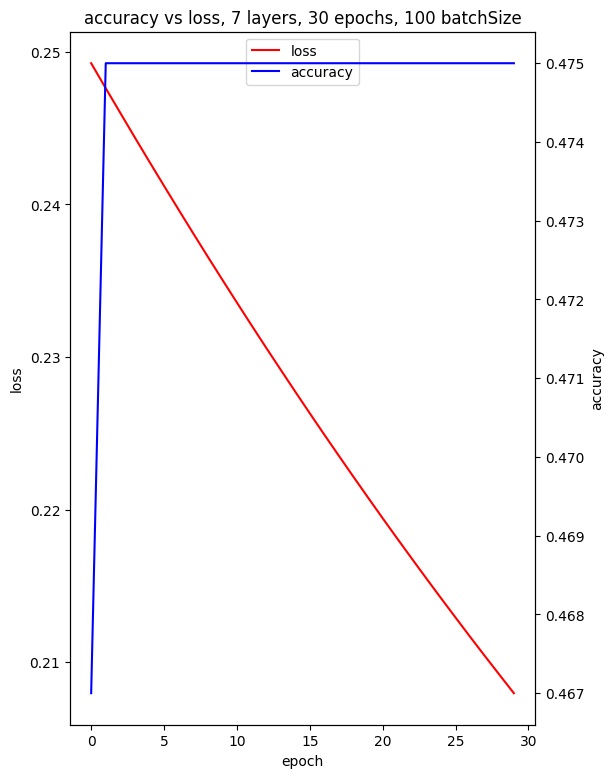

Epoch 1/30
7/7 [==============================] - 1s 68ms/step - loss: 0.2495 - accuracy: 0.4520
Epoch 2/30
7/7 [==============================] - 0s 14ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/30
7/7 [==============================] - 0s 14ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/30
7/7 [==============================] - 0s 15ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/30
7/7 [==============================] - 0s 14ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/30
7/7 [==============================] - 0s 14ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/30
7/7 [==============================] - 0s 14ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/30
7/7 [==============================] - 0s 14ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/30
7/7 [==============================] - 0s 15ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/30
7/7 [==============================] - 0s 15ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/30
7/7 [============

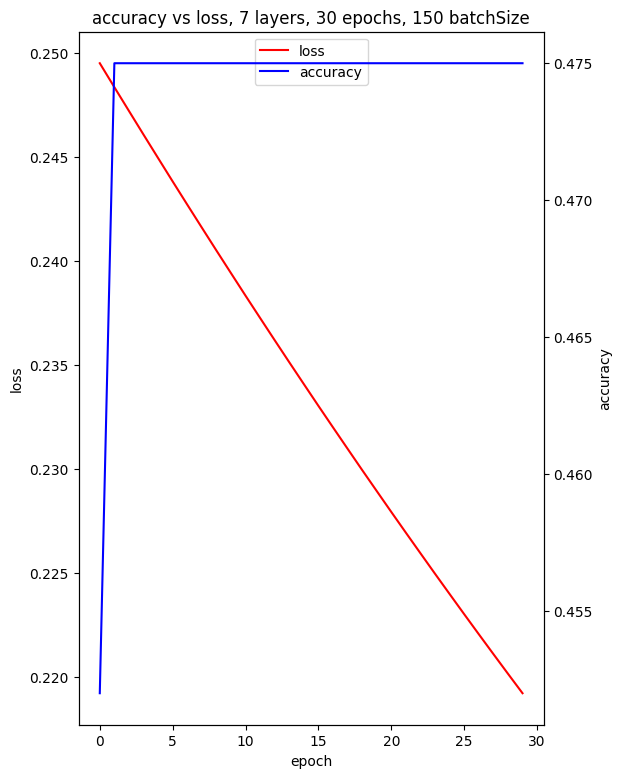

Epoch 1/10
20/20 [==============================] - 1s 15ms/step - loss: 0.2484 - accuracy: 0.4690
Epoch 2/10
20/20 [==============================] - 0s 14ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/10
20/20 [==============================] - 0s 14ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/10
20/20 [==============================] - 0s 14ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/10
20/20 [==============================] - 0s 14ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/10
20/20 [==============================] - 0s 14ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/10
20/20 [==============================] - 0s 14ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/10
20/20 [==============================] - 0s 15ms/step - loss: 0.2216 - accuracy: 0.4750


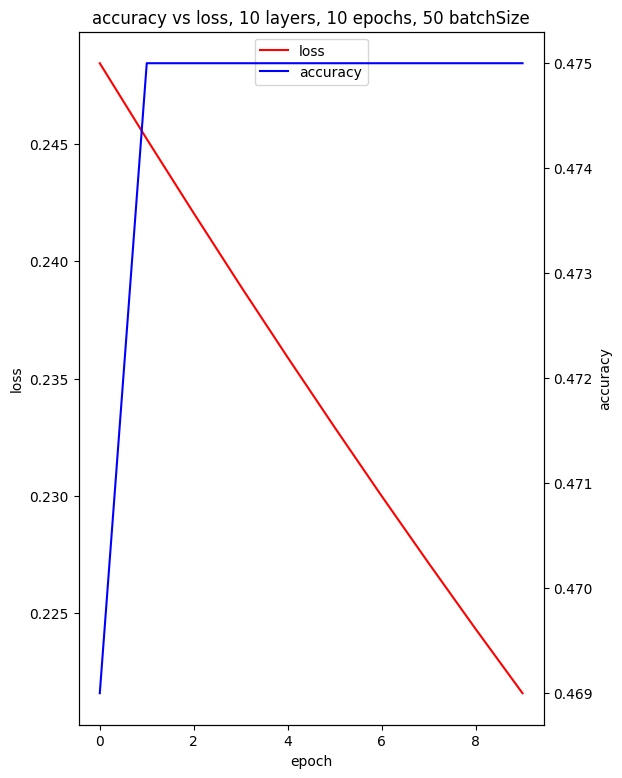

Epoch 1/10
10/10 [==============================] - 1s 17ms/step - loss: 0.2493 - accuracy: 0.4560
Epoch 2/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2351 - accuracy: 0.4750


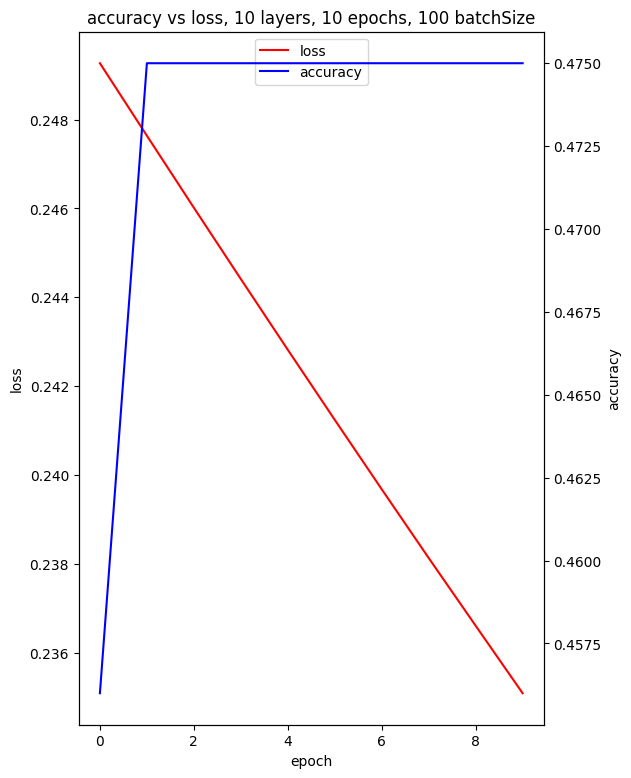

Epoch 1/10
7/7 [==============================] - 1s 20ms/step - loss: 0.2495 - accuracy: 0.4630
Epoch 2/10
7/7 [==============================] - 0s 18ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/10
7/7 [==============================] - 0s 17ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/10
7/7 [==============================] - 0s 17ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/10
7/7 [==============================] - 0s 17ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/10
7/7 [==============================] - 0s 17ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/10
7/7 [==============================] - 0s 17ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/10
7/7 [==============================] - 0s 17ms/step - loss: 0.2394 - accuracy: 0.4750


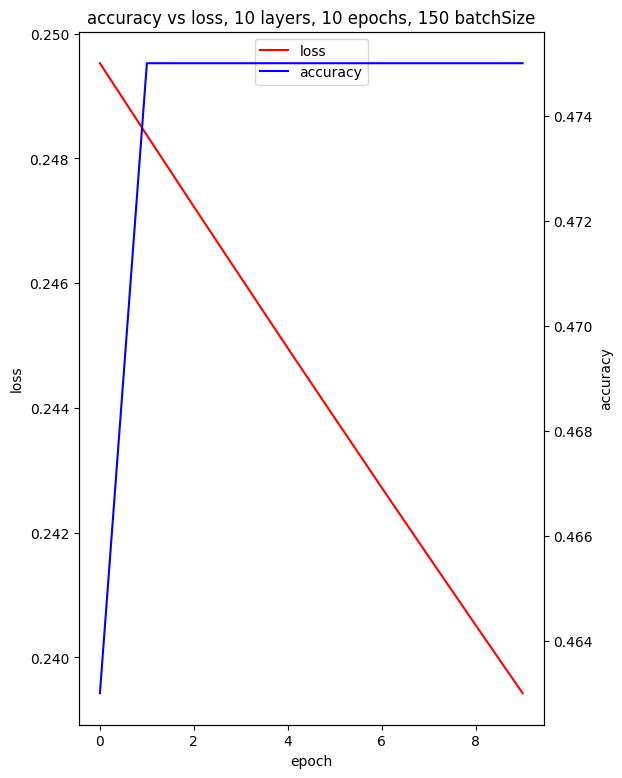

Epoch 1/20
20/20 [==============================] - 1s 14ms/step - loss: 0.2485 - accuracy: 0.4680
Epoch 2/20
20/20 [==============================] - 0s 14ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/20
20/20 [==============================] - 0s 14ms/step - loss: 0.2420 - accuracy: 0.4750
Epoch 4/20
20/20 [==============================] - 0s 15ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/20
20/20 [==============================] - 0s 15ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/20
20/20 [==============================] - 0s 14ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/20
20/20 [==============================] - 0s 14ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/20
20/20 [==============================] - 0s 14ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/20
20/20 [==============================] - 0s 14ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/20
20/20 [==============================] - 0s 14ms/step - loss: 0.2215 - accuracy: 0.4750
Epoch 11/

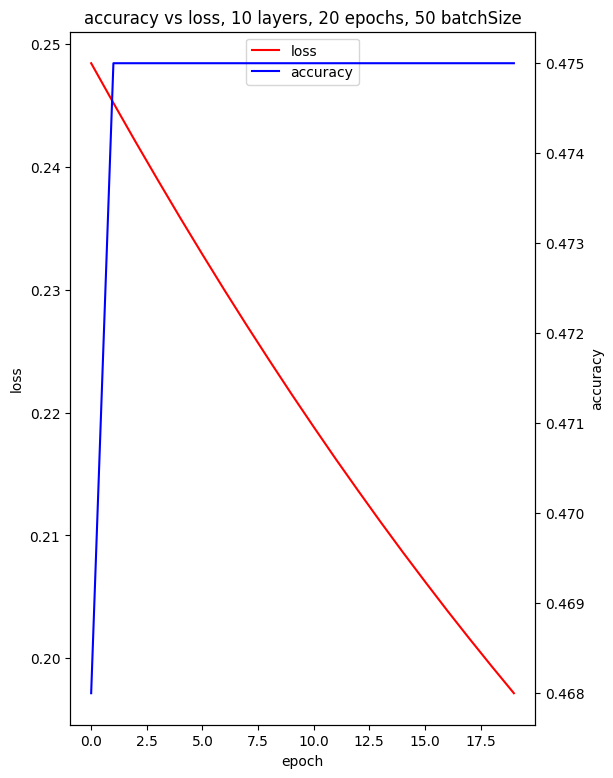

Epoch 1/20
10/10 [==============================] - 1s 16ms/step - loss: 0.2493 - accuracy: 0.4700
Epoch 2/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/20
10/10 [==============================] - 0s 17ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/20
10/10 [==============================] - 0s 15ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/20
10/10 [==============================] - 0s 16ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/

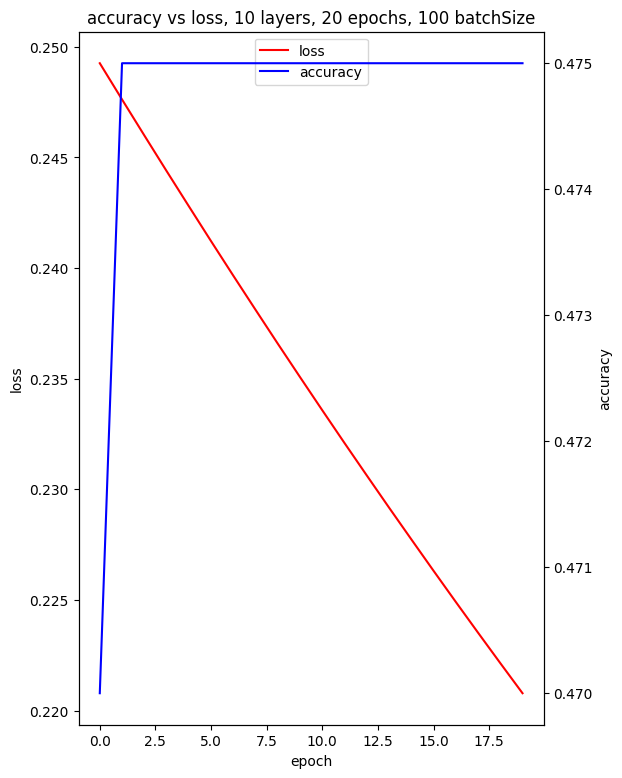

Epoch 1/20
7/7 [==============================] - 1s 19ms/step - loss: 0.2495 - accuracy: 0.4750
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2439 - accuracy: 0.4750
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/20
7/7 [==============================] - 0s 17ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/20
7/7 [============

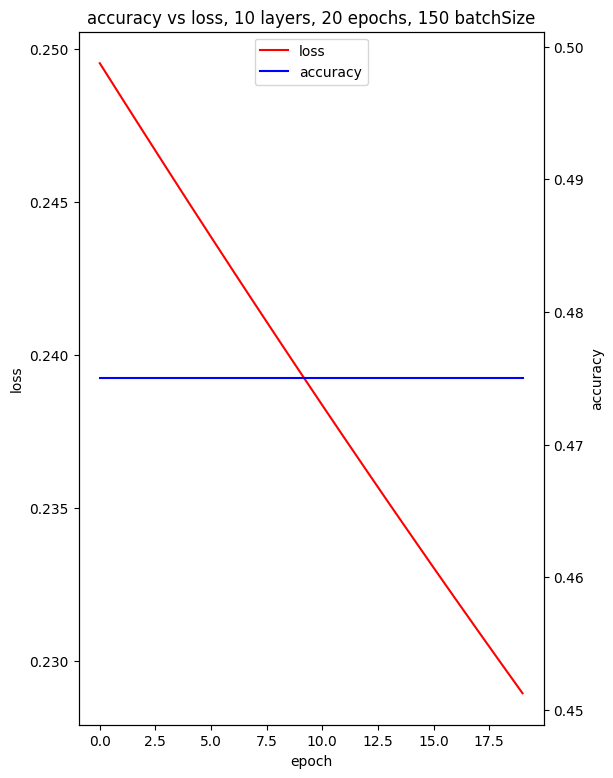

Epoch 1/30
20/20 [==============================] - 1s 15ms/step - loss: 0.2485 - accuracy: 0.4390
Epoch 2/30
20/20 [==============================] - 0s 14ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/30
20/20 [==============================] - 0s 14ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/30
20/20 [==============================] - 0s 13ms/step - loss: 0.2390 - accuracy: 0.4750
Epoch 5/30
20/20 [==============================] - 0s 14ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/30
20/20 [==============================] - 0s 14ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/30
20/20 [==============================] - 0s 14ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/30
20/20 [==============================] - 0s 14ms/step - loss: 0.2272 - accuracy: 0.4750
Epoch 9/30
20/20 [==============================] - 0s 14ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/30
20/20 [==============================] - 0s 14ms/step - loss: 0.2216 - accuracy: 0.4750
Epoch 11/

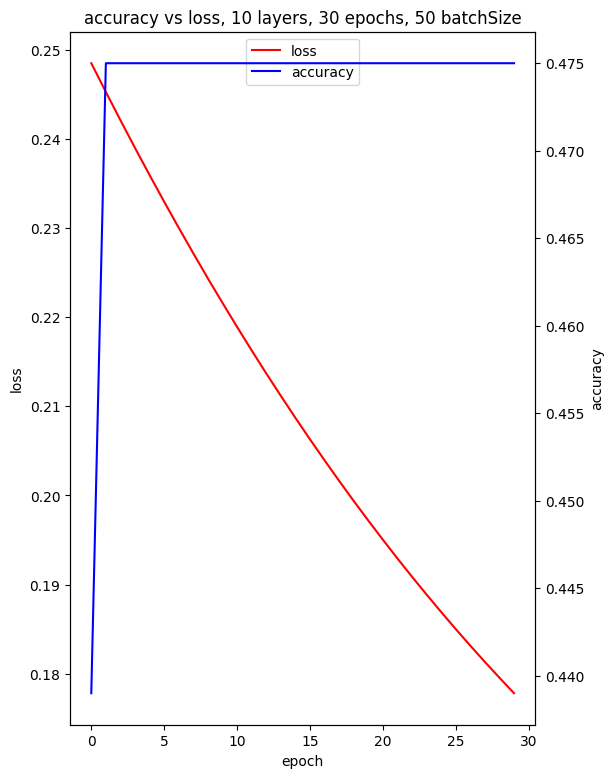

Epoch 1/30
10/10 [==============================] - 1s 17ms/step - loss: 0.2493 - accuracy: 0.4590
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/30
10/10 [==============================] - 0s 16ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/30
10/10 [==============================] - 0s 15ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/30
10/10 [==============================] - 0s 15ms/step - loss: 0.2396 - accuracy: 0.4750
Epoch 8/30
10/10 [==============================] - 0s 15ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/30
10/10 [==============================] - 0s 16ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/30
10/10 [==============================] - 0s 16ms/step - loss: 0.2350 - accuracy: 0.4750
Epoch 11/

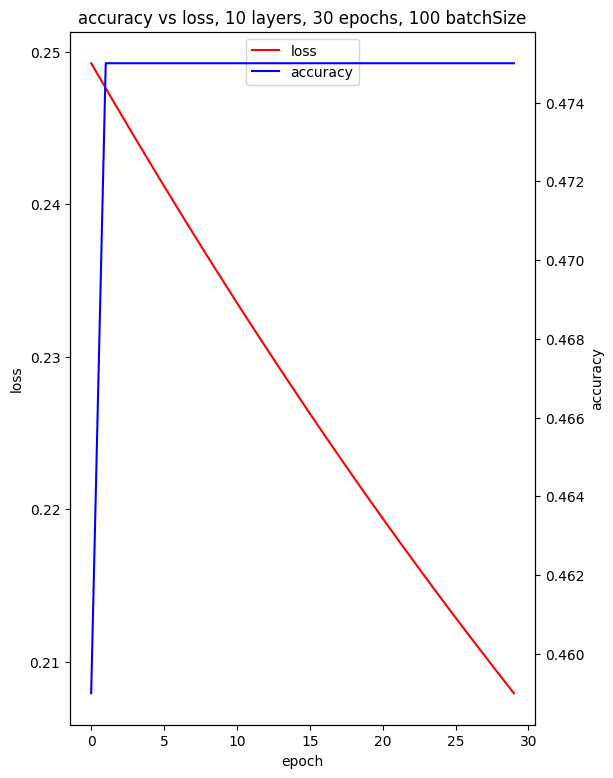

Epoch 1/30
7/7 [==============================] - 1s 19ms/step - loss: 0.2495 - accuracy: 0.4520
Epoch 2/30
7/7 [==============================] - 0s 17ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/30
7/7 [==============================] - 0s 17ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/30
7/7 [==============================] - 0s 17ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/30
7/7 [==============================] - 0s 18ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/30
7/7 [==============================] - 0s 31ms/step - loss: 0.2439 - accuracy: 0.4750
Epoch 7/30
7/7 [==============================] - 0s 19ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/30
7/7 [==============================] - 0s 16ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/30
7/7 [==============================] - 0s 16ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/30
7/7 [==============================] - 0s 17ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/30
7/7 [============

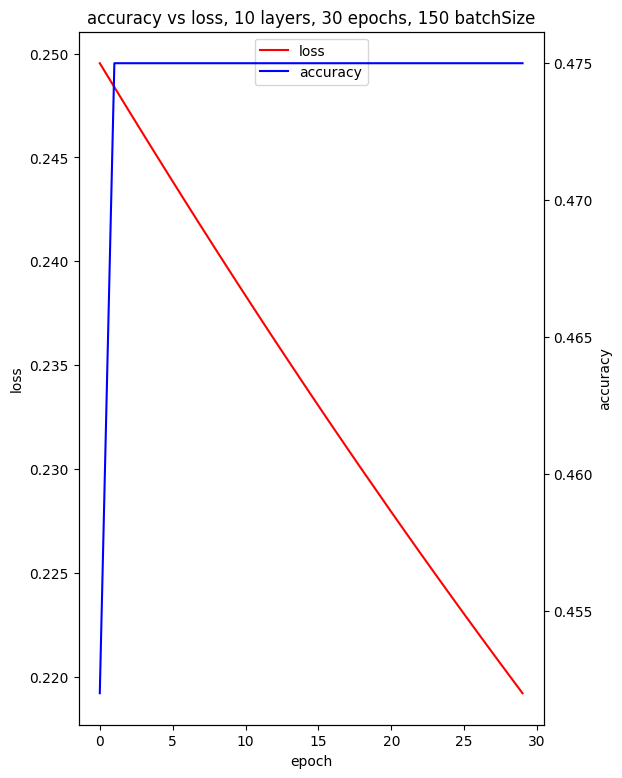

Epoch 1/10
20/20 [==============================] - 1s 20ms/step - loss: 0.2485 - accuracy: 0.4520
Epoch 2/10
20/20 [==============================] - 0s 18ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/10
20/20 [==============================] - 0s 17ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/10
20/20 [==============================] - 0s 18ms/step - loss: 0.2390 - accuracy: 0.4750
Epoch 5/10
20/20 [==============================] - 0s 18ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/10
20/20 [==============================] - 0s 18ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/10
20/20 [==============================] - 0s 18ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/10
20/20 [==============================] - 0s 18ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/10
20/20 [==============================] - 0s 18ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/10
20/20 [==============================] - 0s 17ms/step - loss: 0.2216 - accuracy: 0.4750


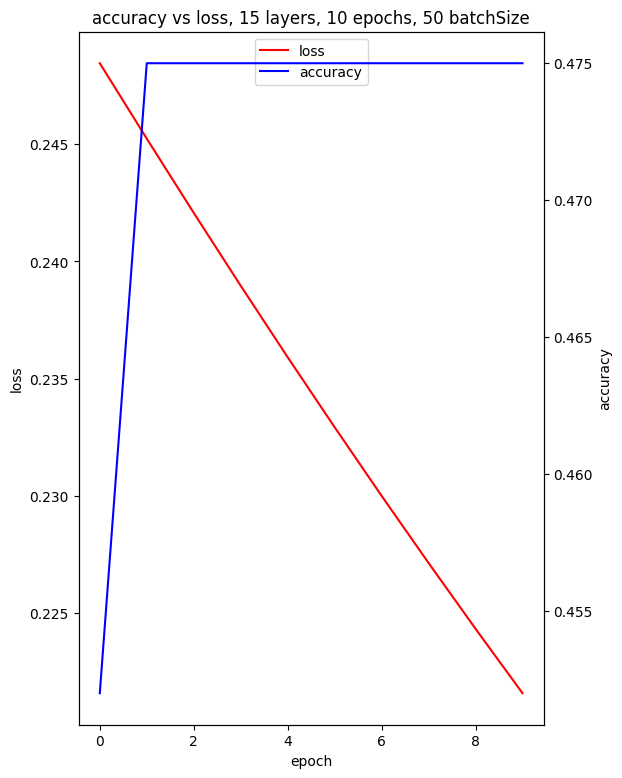

Epoch 1/10
10/10 [==============================] - 1s 21ms/step - loss: 0.2493 - accuracy: 0.4780
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/10
10/10 [==============================] - 0s 22ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/10
10/10 [==============================] - 0s 21ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/10
10/10 [==============================] - 0s 20ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/10
10/10 [==============================] - 0s 20ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/10
10/10 [==============================] - 0s 20ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/10
10/10 [==============================] - 0s 20ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/10
10/10 [==============================] - 0s 20ms/step - loss: 0.2351 - accuracy: 0.4750


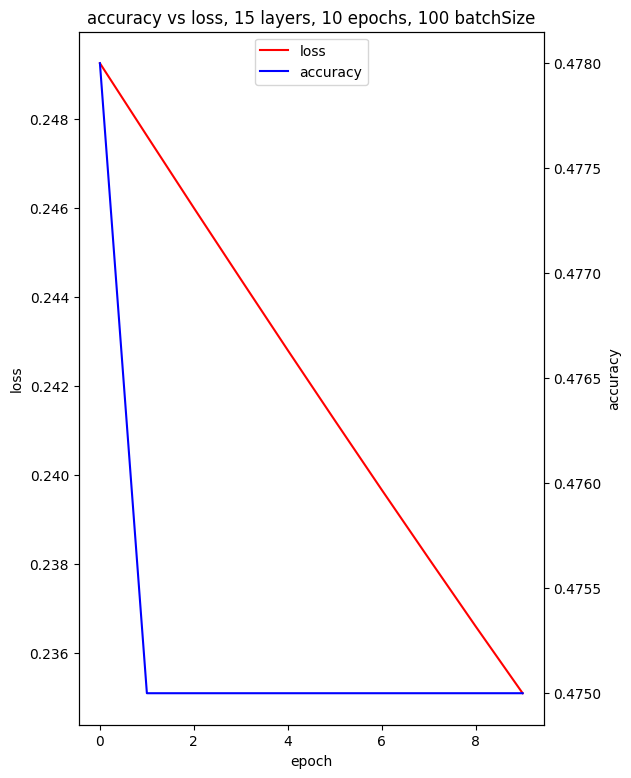

Epoch 1/10
7/7 [==============================] - 1s 25ms/step - loss: 0.2495 - accuracy: 0.4520
Epoch 2/10
7/7 [==============================] - 0s 35ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/10
7/7 [==============================] - 0s 26ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/10
7/7 [==============================] - 0s 22ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/10
7/7 [==============================] - 0s 22ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/10
7/7 [==============================] - 0s 20ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/10
7/7 [==============================] - 0s 22ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/10
7/7 [==============================] - 0s 22ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/10
7/7 [==============================] - 0s 22ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/10
7/7 [==============================] - 0s 23ms/step - loss: 0.2394 - accuracy: 0.4750


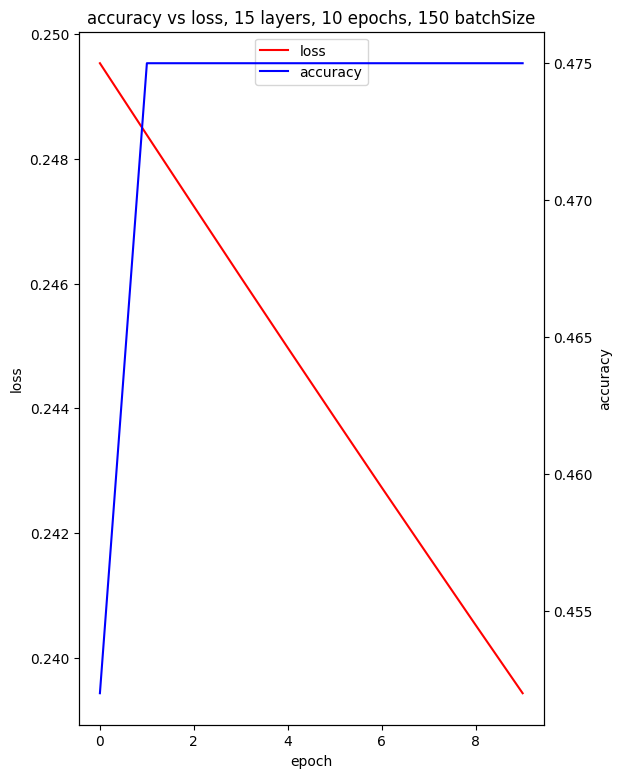

Epoch 1/20
20/20 [==============================] - 1s 19ms/step - loss: 0.2484 - accuracy: 0.4700
Epoch 2/20
20/20 [==============================] - 0s 20ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/20
20/20 [==============================] - 0s 18ms/step - loss: 0.2420 - accuracy: 0.4750
Epoch 4/20
20/20 [==============================] - 0s 18ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/20
20/20 [==============================] - 0s 18ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/20
20/20 [==============================] - 0s 18ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/20
20/20 [==============================] - 0s 17ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/20
20/20 [==============================] - 0s 18ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/20
20/20 [==============================] - 0s 17ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/20
20/20 [==============================] - 0s 17ms/step - loss: 0.2216 - accuracy: 0.4750
Epoch 11/

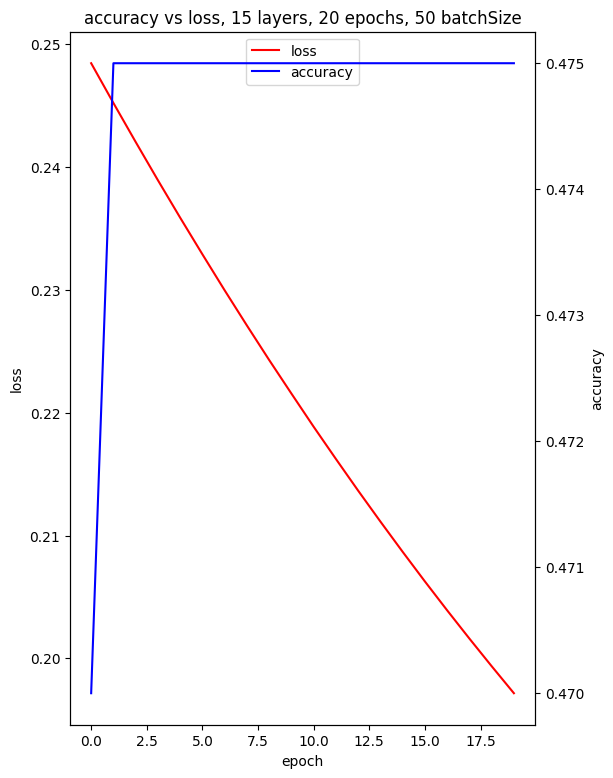

Epoch 1/20
10/10 [==============================] - 1s 21ms/step - loss: 0.2493 - accuracy: 0.4670
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/20
10/10 [==============================] - 0s 19ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/20
10/10 [==============================] - 0s 19ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/20
10/10 [==============================] - 0s 19ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/20
10/10 [==============================] - 0s 19ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/

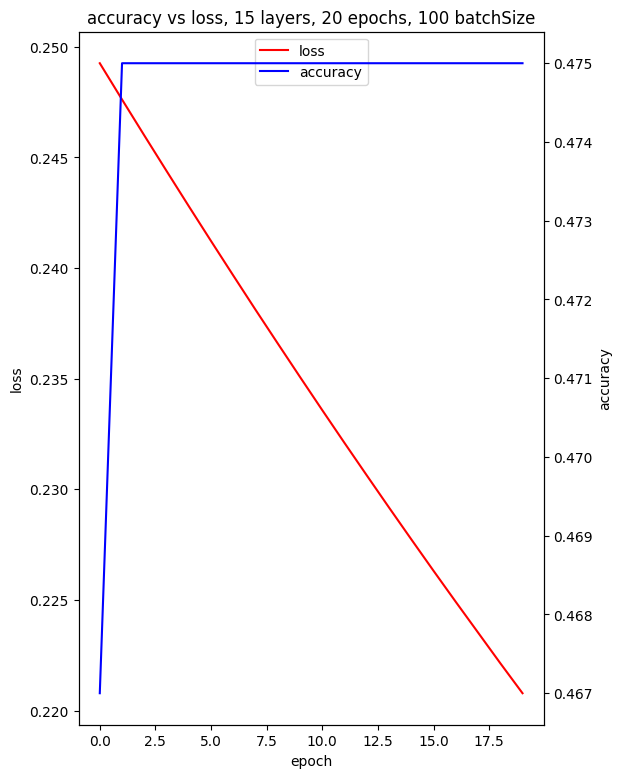

Epoch 1/20
7/7 [==============================] - 2s 24ms/step - loss: 0.2495 - accuracy: 0.4530
Epoch 2/20
7/7 [==============================] - 0s 21ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/20
7/7 [==============================] - 0s 22ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/20
7/7 [==============================] - 0s 21ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/20
7/7 [==============================] - 0s 22ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/20
7/7 [==============================] - 0s 24ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/20
7/7 [==============================] - 0s 24ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/20
7/7 [==============================] - 0s 20ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/20
7/7 [============

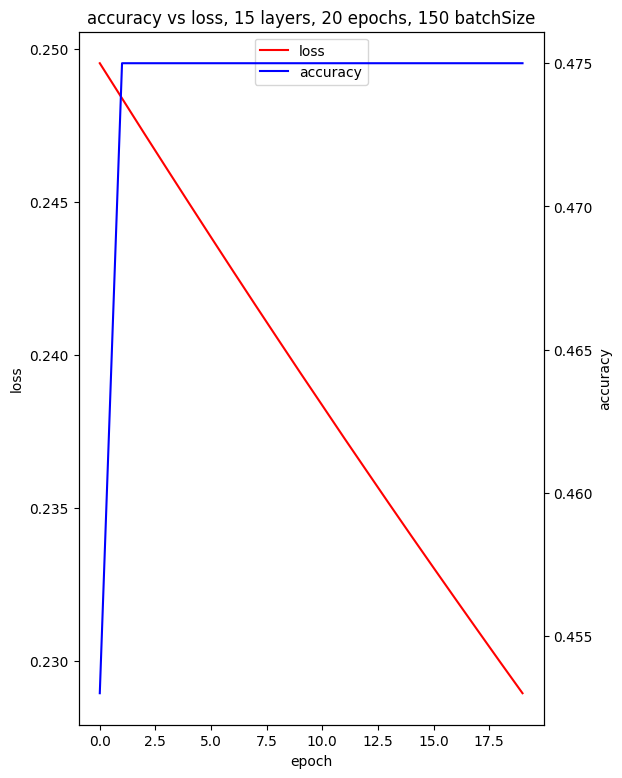

Epoch 1/30
20/20 [==============================] - 1s 18ms/step - loss: 0.2484 - accuracy: 0.4690
Epoch 2/30
20/20 [==============================] - 0s 18ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/30
20/20 [==============================] - 0s 18ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/30
20/20 [==============================] - 0s 18ms/step - loss: 0.2390 - accuracy: 0.4750
Epoch 5/30
20/20 [==============================] - 0s 18ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/30
20/20 [==============================] - 0s 18ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/30
20/20 [==============================] - 0s 19ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/30
20/20 [==============================] - 0s 18ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/30
20/20 [==============================] - 0s 18ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/30
20/20 [==============================] - 0s 18ms/step - loss: 0.2216 - accuracy: 0.4750
Epoch 11/

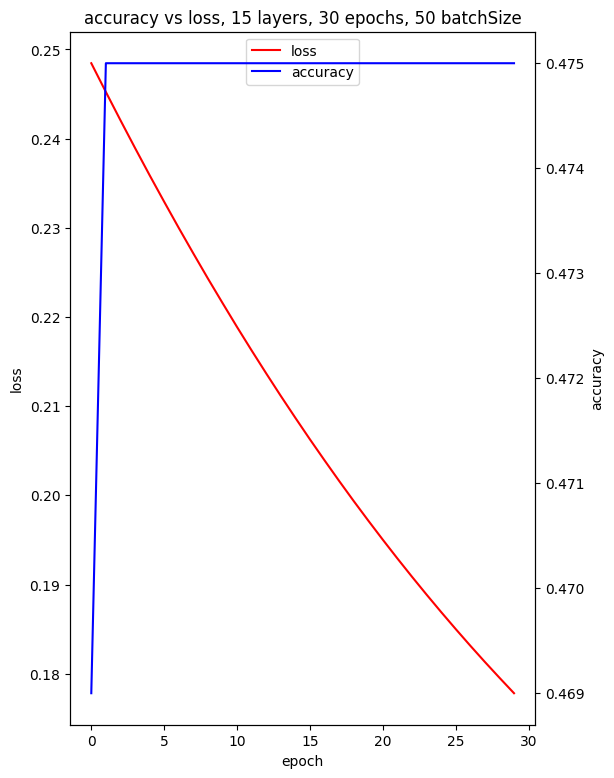

Epoch 1/30
10/10 [==============================] - 1s 24ms/step - loss: 0.2493 - accuracy: 0.4600
Epoch 2/30
10/10 [==============================] - 0s 20ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/30
10/10 [==============================] - 0s 19ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/30
10/10 [==============================] - 0s 20ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/30
10/10 [==============================] - 0s 19ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/30
10/10 [==============================] - 0s 19ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/30
10/10 [==============================] - 0s 20ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/30
10/10 [==============================] - 0s 20ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/30
10/10 [==============================] - 0s 20ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/30
10/10 [==============================] - 0s 20ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/

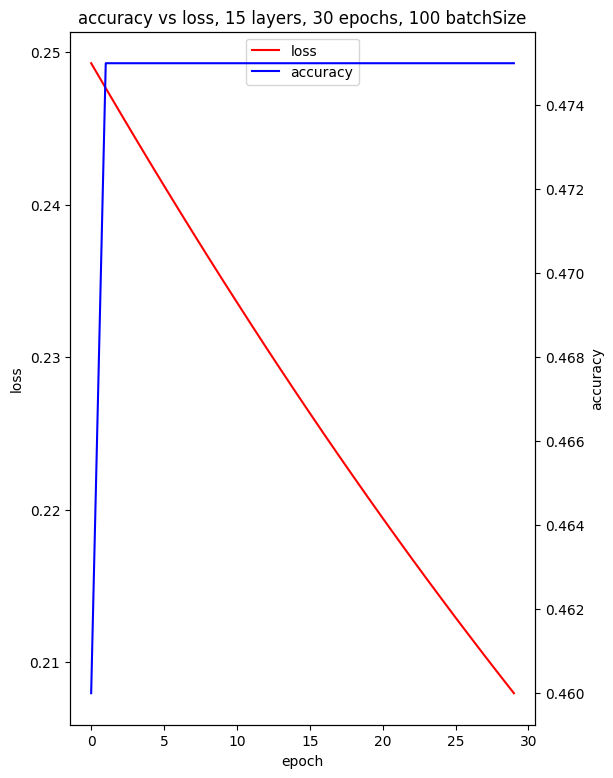

Epoch 1/30
7/7 [==============================] - 1s 24ms/step - loss: 0.2495 - accuracy: 0.4400
Epoch 2/30
7/7 [==============================] - 0s 22ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/30
7/7 [==============================] - 0s 21ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/30
7/7 [==============================] - 0s 20ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/30
7/7 [==============================] - 0s 23ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/30
7/7 [==============================] - 0s 21ms/step - loss: 0.2439 - accuracy: 0.4750
Epoch 7/30
7/7 [==============================] - 0s 20ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/30
7/7 [==============================] - 0s 21ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/30
7/7 [==============================] - 0s 21ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/30
7/7 [==============================] - 0s 22ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/30
7/7 [============

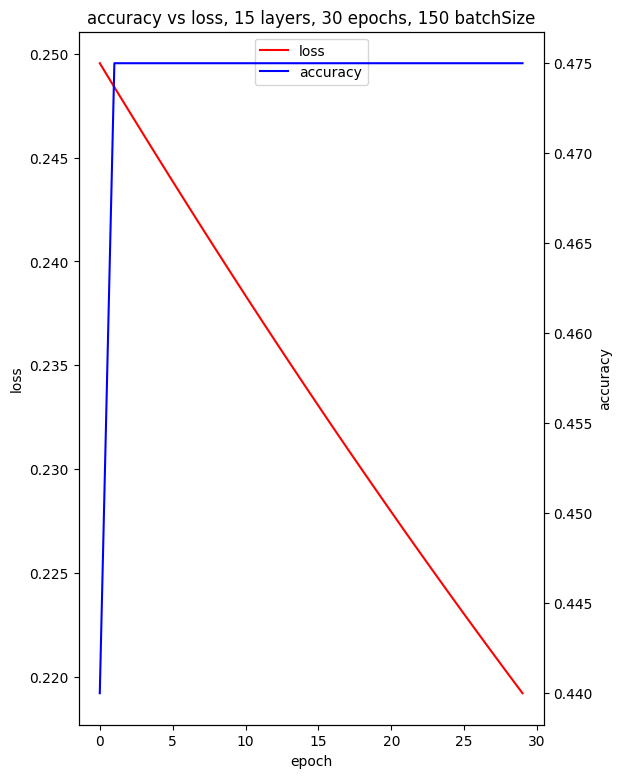

Epoch 1/10
20/20 [==============================] - 2s 22ms/step - loss: 0.2485 - accuracy: 0.4640
Epoch 2/10
20/20 [==============================] - 0s 20ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/10
20/20 [==============================] - 0s 20ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/10
20/20 [==============================] - 0s 21ms/step - loss: 0.2390 - accuracy: 0.4750
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/10
20/20 [==============================] - 0s 22ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/10
20/20 [==============================] - 0s 22ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/10
20/20 [==============================] - 0s 22ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/10
20/20 [==============================] - 0s 22ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/10
20/20 [==============================] - 0s 21ms/step - loss: 0.2216 - accuracy: 0.4750


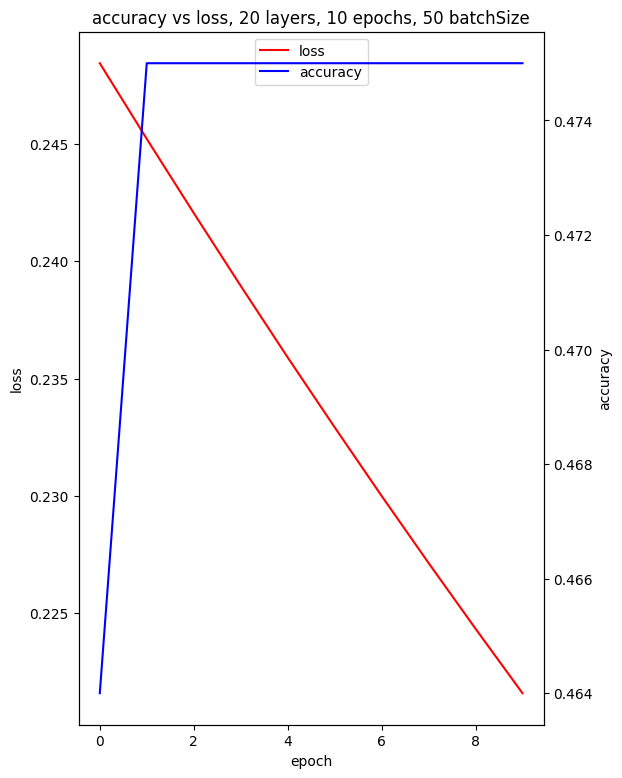

Epoch 1/10
10/10 [==============================] - 1s 27ms/step - loss: 0.2493 - accuracy: 0.4680
Epoch 2/10
10/10 [==============================] - 0s 24ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/10
10/10 [==============================] - 0s 24ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/10
10/10 [==============================] - 0s 23ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/10
10/10 [==============================] - 0s 25ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/10
10/10 [==============================] - 0s 26ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/10
10/10 [==============================] - 0s 24ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/10
10/10 [==============================] - 0s 25ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/10
10/10 [==============================] - 0s 25ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/10
10/10 [==============================] - 0s 25ms/step - loss: 0.2351 - accuracy: 0.4750


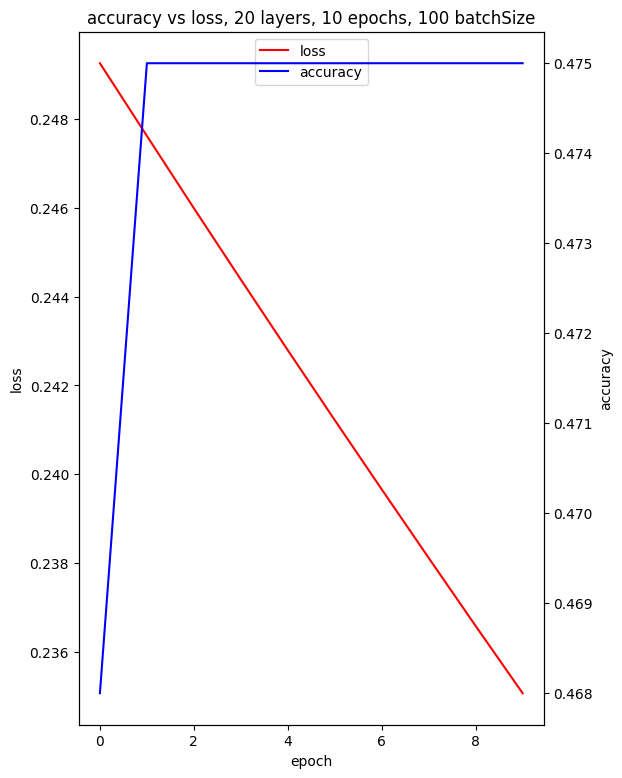

Epoch 1/10
7/7 [==============================] - 1s 29ms/step - loss: 0.2495 - accuracy: 0.4390
Epoch 2/10
7/7 [==============================] - 0s 27ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/10
7/7 [==============================] - 0s 26ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/10
7/7 [==============================] - 0s 27ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/10
7/7 [==============================] - 0s 26ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/10
7/7 [==============================] - 0s 27ms/step - loss: 0.2439 - accuracy: 0.4750
Epoch 7/10
7/7 [==============================] - 0s 27ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/10
7/7 [==============================] - 0s 27ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/10
7/7 [==============================] - 0s 28ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/10
7/7 [==============================] - 0s 28ms/step - loss: 0.2394 - accuracy: 0.4750


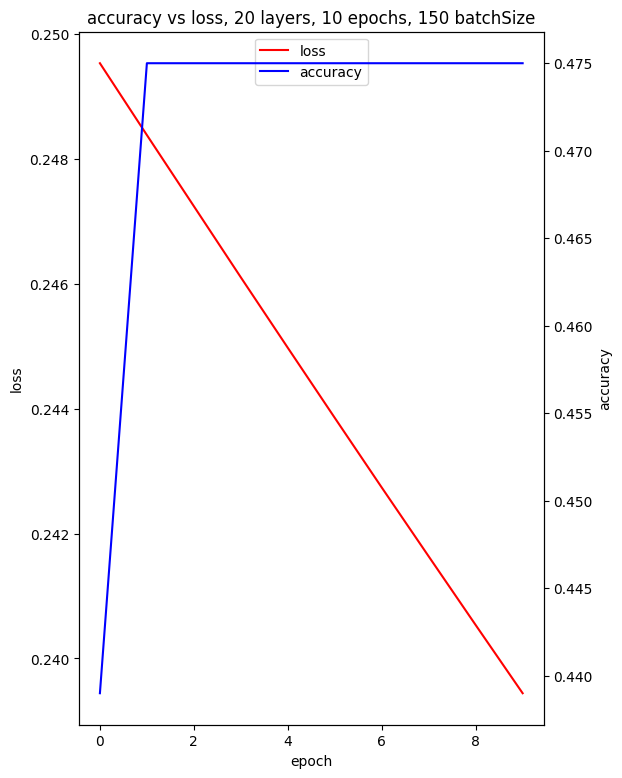

Epoch 1/20
20/20 [==============================] - 1s 24ms/step - loss: 0.2485 - accuracy: 0.4670
Epoch 2/20
20/20 [==============================] - 0s 22ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/20
20/20 [==============================] - 0s 21ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/20
20/20 [==============================] - 0s 22ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/20
20/20 [==============================] - 0s 21ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/20
20/20 [==============================] - 0s 21ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/20
20/20 [==============================] - 0s 21ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/20
20/20 [==============================] - 0s 21ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/20
20/20 [==============================] - 0s 22ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/20
20/20 [==============================] - 0s 22ms/step - loss: 0.2216 - accuracy: 0.4750
Epoch 11/

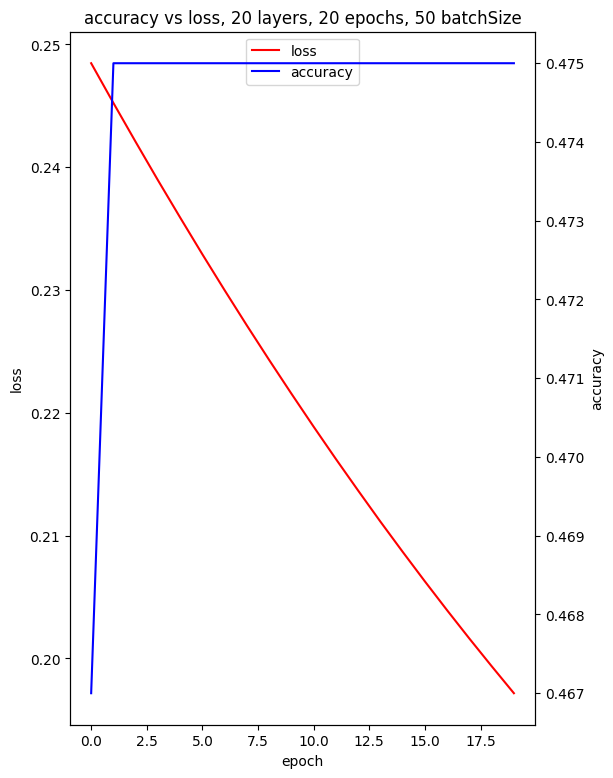

Epoch 1/20
10/10 [==============================] - 1s 26ms/step - loss: 0.2493 - accuracy: 0.4360
Epoch 2/20
10/10 [==============================] - 0s 25ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/20
10/10 [==============================] - 0s 24ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/20
10/10 [==============================] - 0s 24ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/20
10/10 [==============================] - 0s 25ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/20
10/10 [==============================] - 0s 25ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/20
10/10 [==============================] - 0s 27ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/20
10/10 [==============================] - 0s 25ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/20
10/10 [==============================] - 0s 24ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/20
10/10 [==============================] - 0s 26ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/

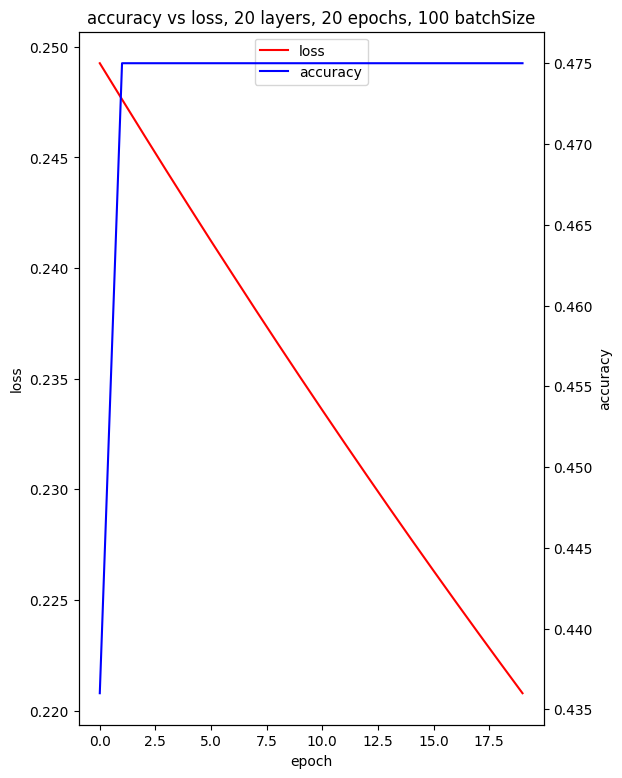

Epoch 1/20
7/7 [==============================] - 1s 31ms/step - loss: 0.2495 - accuracy: 0.4710
Epoch 2/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/20
7/7 [==============================] - 0s 26ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/20
7/7 [==============================] - 0s 26ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/20
7/7 [==============================] - 0s 28ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/20
7/7 [==============================] - 0s 28ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/20
7/7 [============

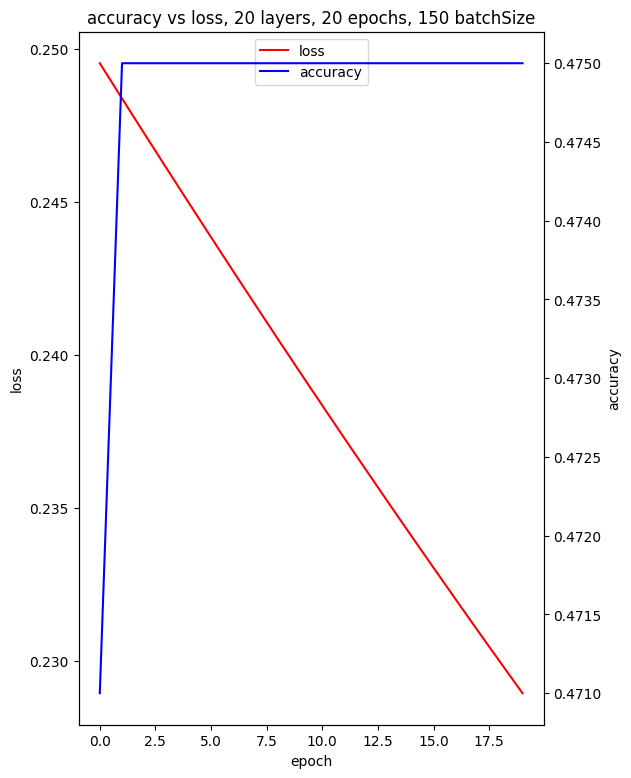

Epoch 1/30
20/20 [==============================] - 1s 22ms/step - loss: 0.2485 - accuracy: 0.4720
Epoch 2/30
20/20 [==============================] - 0s 22ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/30
20/20 [==============================] - 0s 21ms/step - loss: 0.2420 - accuracy: 0.4750
Epoch 4/30
20/20 [==============================] - 0s 22ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/30
20/20 [==============================] - 0s 22ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/30
20/20 [==============================] - 0s 21ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/30
20/20 [==============================] - 0s 21ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/30
20/20 [==============================] - 0s 21ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/30
20/20 [==============================] - 0s 22ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/30
20/20 [==============================] - 0s 21ms/step - loss: 0.2215 - accuracy: 0.4750
Epoch 11/

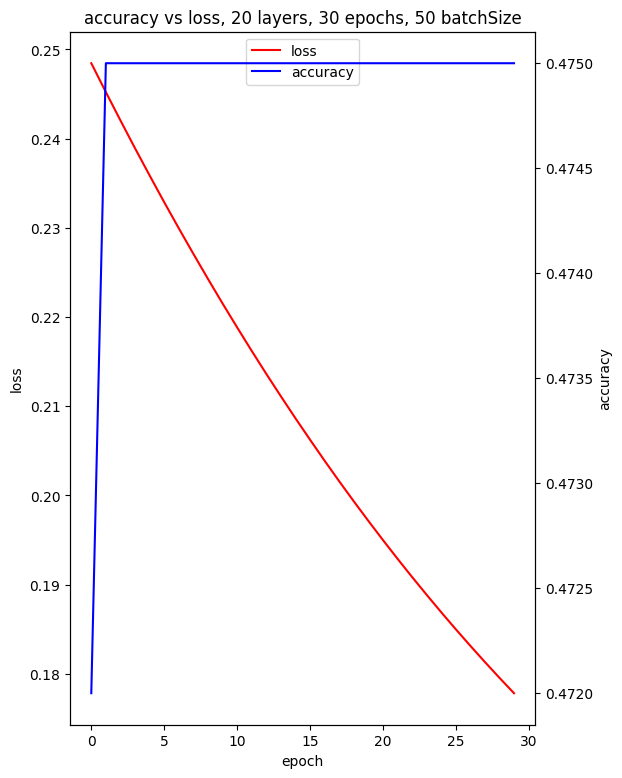

Epoch 1/30
10/10 [==============================] - 4s 332ms/step - loss: 0.2493 - accuracy: 0.4610
Epoch 2/30
10/10 [==============================] - 0s 25ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/30
10/10 [==============================] - 0s 26ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/30
10/10 [==============================] - 0s 25ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/30
10/10 [==============================] - 0s 28ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/30
10/10 [==============================] - 0s 25ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/30
10/10 [==============================] - 0s 27ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/30
10/10 [==============================] - 0s 25ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/30
10/10 [==============================] - 0s 25ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/30
10/10 [==============================] - 0s 26ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11

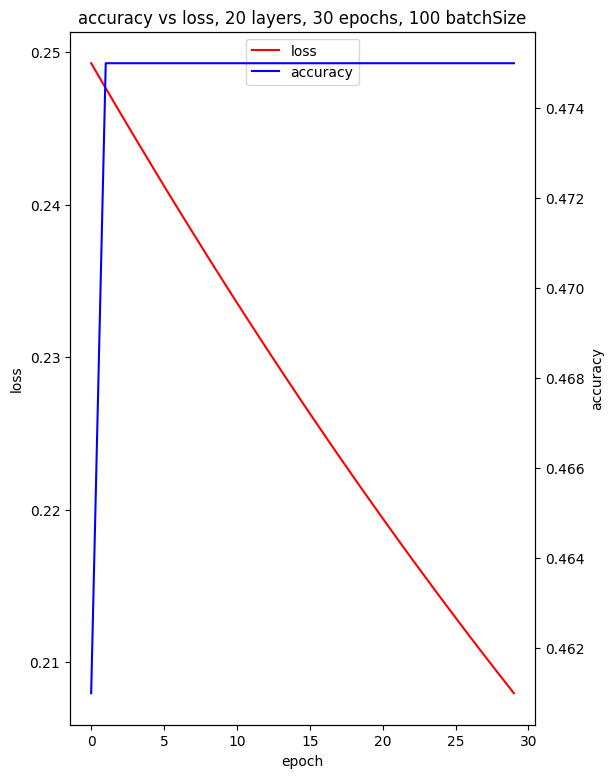

Epoch 1/30
7/7 [==============================] - 1s 31ms/step - loss: 0.2495 - accuracy: 0.4550
Epoch 2/30
7/7 [==============================] - 0s 31ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/30
7/7 [==============================] - 0s 30ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/30
7/7 [==============================] - 0s 27ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/30
7/7 [==============================] - 0s 29ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/30
7/7 [==============================] - 0s 28ms/step - loss: 0.2439 - accuracy: 0.4750
Epoch 7/30
7/7 [==============================] - 0s 28ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/30
7/7 [==============================] - 0s 25ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/30
7/7 [==============================] - 0s 29ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/30
7/7 [==============================] - 0s 30ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/30
7/7 [============

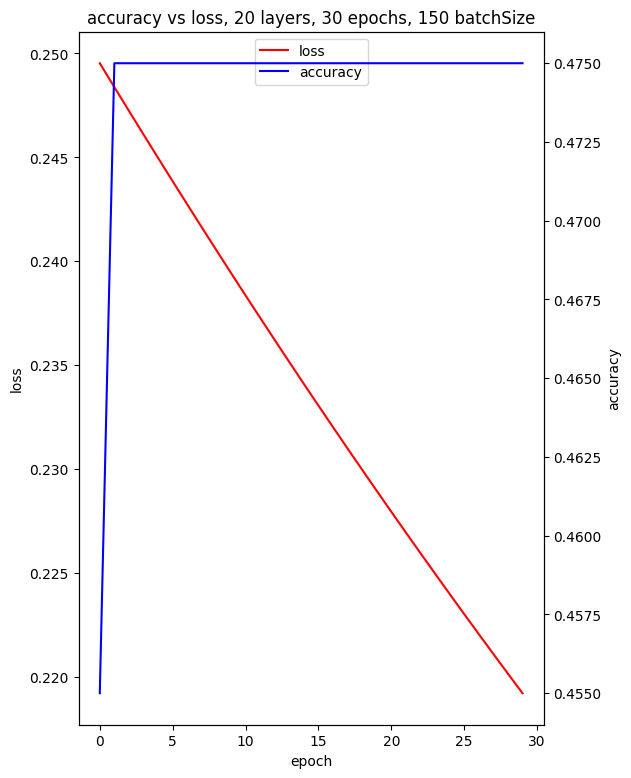

Epoch 1/10
20/20 [==============================] - 3s 52ms/step - loss: 0.2485 - accuracy: 0.4560
Epoch 2/10
20/20 [==============================] - 1s 51ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/10
20/20 [==============================] - 1s 47ms/step - loss: 0.2421 - accuracy: 0.4750
Epoch 4/10
20/20 [==============================] - 1s 46ms/step - loss: 0.2390 - accuracy: 0.4750
Epoch 5/10
20/20 [==============================] - 1s 48ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/10
20/20 [==============================] - 1s 48ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/10
20/20 [==============================] - 1s 46ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/10
20/20 [==============================] - 1s 48ms/step - loss: 0.2272 - accuracy: 0.4750
Epoch 9/10
20/20 [==============================] - 1s 48ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/10
20/20 [==============================] - 1s 46ms/step - loss: 0.2216 - accuracy: 0.4750


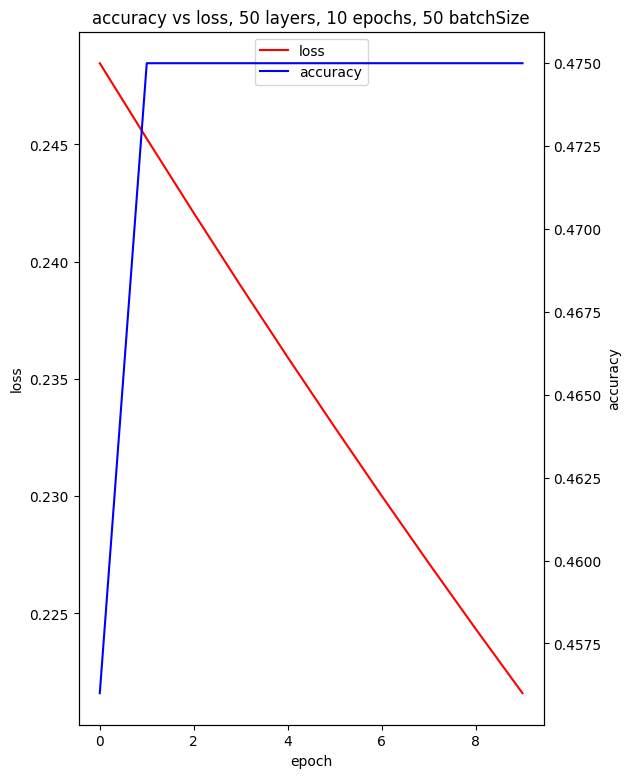

Epoch 1/10
10/10 [==============================] - 3s 52ms/step - loss: 0.2493 - accuracy: 0.4420
Epoch 2/10
10/10 [==============================] - 1s 56ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/10
10/10 [==============================] - 1s 59ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/10
10/10 [==============================] - 1s 57ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/10
10/10 [==============================] - 1s 60ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/10
10/10 [==============================] - 1s 59ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/10
10/10 [==============================] - 1s 60ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/10
10/10 [==============================] - 1s 59ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/10
10/10 [==============================] - 1s 58ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/10
10/10 [==============================] - 1s 58ms/step - loss: 0.2351 - accuracy: 0.4750


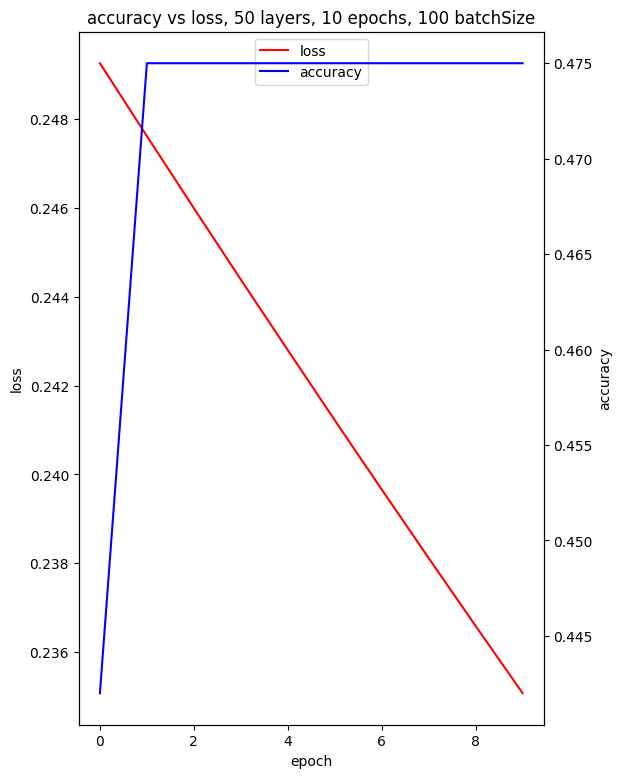

Epoch 1/10
7/7 [==============================] - 2s 55ms/step - loss: 0.2495 - accuracy: 0.4530
Epoch 2/10
7/7 [==============================] - 0s 63ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/10
7/7 [==============================] - 0s 67ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/10
7/7 [==============================] - 0s 67ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/10
7/7 [==============================] - 0s 66ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/10
7/7 [==============================] - 0s 66ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/10
7/7 [==============================] - 0s 65ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/10
7/7 [==============================] - 0s 65ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/10
7/7 [==============================] - 0s 65ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/10
7/7 [==============================] - 0s 67ms/step - loss: 0.2394 - accuracy: 0.4750


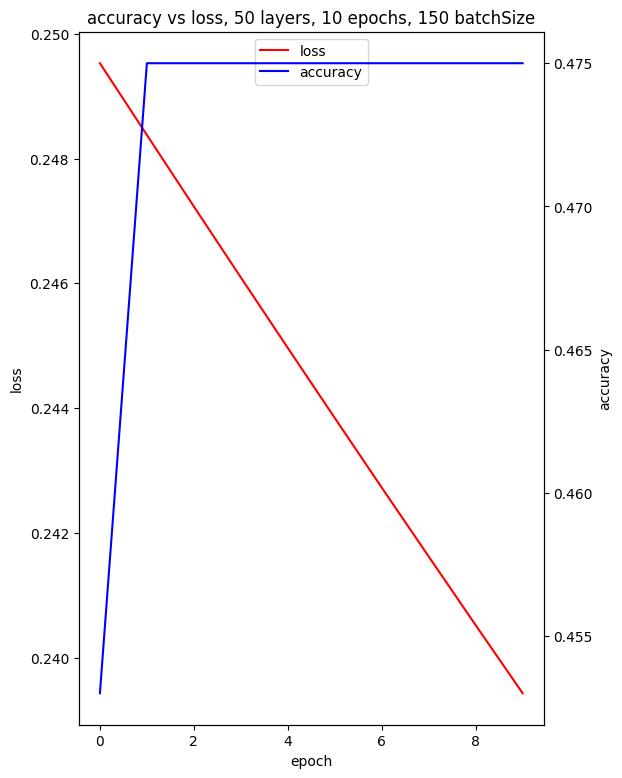

Epoch 1/20
20/20 [==============================] - 3s 48ms/step - loss: 0.2485 - accuracy: 0.4580
Epoch 2/20
20/20 [==============================] - 1s 48ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/20
20/20 [==============================] - 1s 47ms/step - loss: 0.2420 - accuracy: 0.4750
Epoch 4/20
20/20 [==============================] - 1s 48ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/20
20/20 [==============================] - 1s 47ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/20
20/20 [==============================] - 1s 47ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/20
20/20 [==============================] - 1s 48ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/20
20/20 [==============================] - 1s 47ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/20
20/20 [==============================] - 1s 48ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/20
20/20 [==============================] - 1s 47ms/step - loss: 0.2215 - accuracy: 0.4750
Epoch 11/

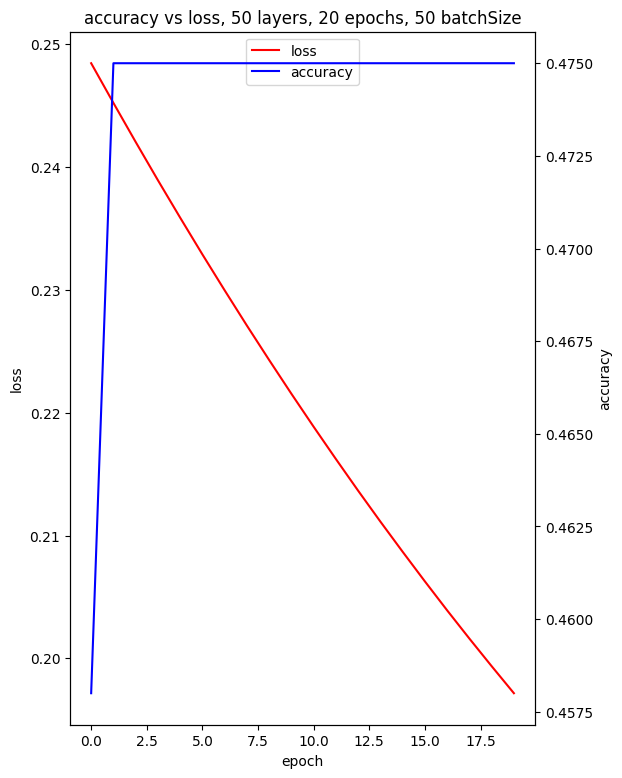

Epoch 1/20
10/10 [==============================] - 3s 64ms/step - loss: 0.2493 - accuracy: 0.4590
Epoch 2/20
10/10 [==============================] - 1s 63ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/20
10/10 [==============================] - 1s 62ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/20
10/10 [==============================] - 1s 67ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/20
10/10 [==============================] - 1s 64ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/20
10/10 [==============================] - 1s 63ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/20
10/10 [==============================] - 1s 65ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/20
10/10 [==============================] - 1s 62ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/20
10/10 [==============================] - 1s 62ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/20
10/10 [==============================] - 1s 63ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/

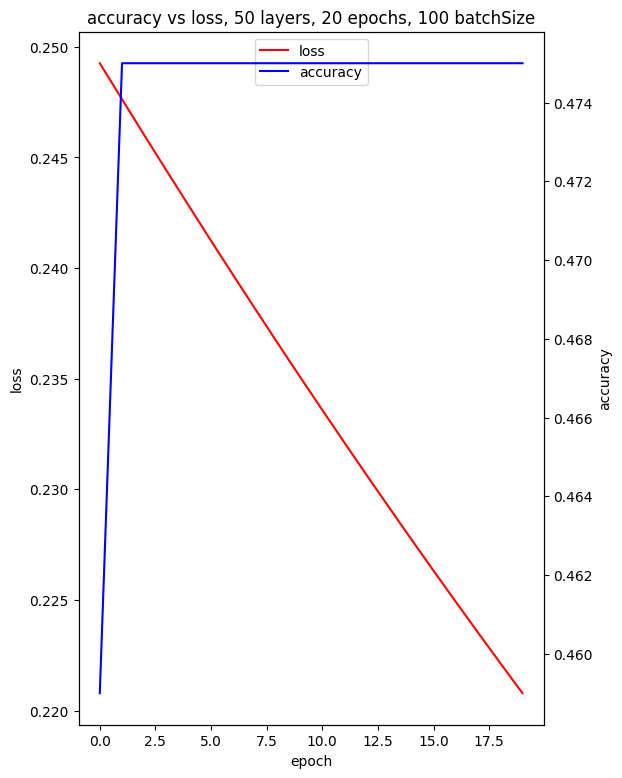

Epoch 1/20
7/7 [==============================] - 2s 62ms/step - loss: 0.2495 - accuracy: 0.4670
Epoch 2/20
7/7 [==============================] - 0s 64ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/20
7/7 [==============================] - 0s 69ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/20
7/7 [==============================] - 0s 67ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/20
7/7 [==============================] - 0s 69ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/20
7/7 [==============================] - 0s 65ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/20
7/7 [==============================] - 0s 64ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/20
7/7 [==============================] - 0s 67ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/20
7/7 [==============================] - 0s 67ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/20
7/7 [==============================] - 0s 67ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/20
7/7 [============

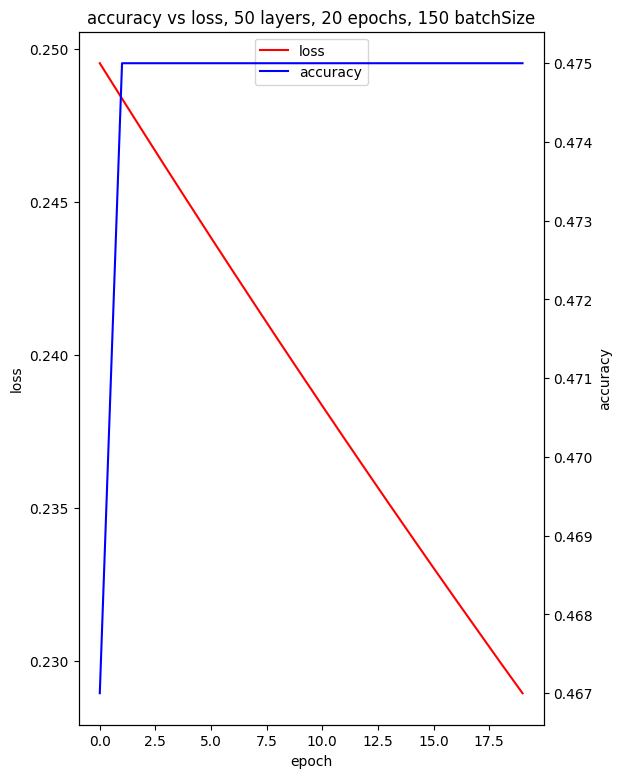

Epoch 1/30
20/20 [==============================] - 9s 50ms/step - loss: 0.2484 - accuracy: 0.4640
Epoch 2/30
20/20 [==============================] - 1s 54ms/step - loss: 0.2452 - accuracy: 0.4750
Epoch 3/30
20/20 [==============================] - 1s 56ms/step - loss: 0.2420 - accuracy: 0.4750
Epoch 4/30
20/20 [==============================] - 1s 65ms/step - loss: 0.2389 - accuracy: 0.4750
Epoch 5/30
20/20 [==============================] - 1s 52ms/step - loss: 0.2359 - accuracy: 0.4750
Epoch 6/30
20/20 [==============================] - 1s 53ms/step - loss: 0.2329 - accuracy: 0.4750
Epoch 7/30
20/20 [==============================] - 1s 56ms/step - loss: 0.2300 - accuracy: 0.4750
Epoch 8/30
20/20 [==============================] - 1s 52ms/step - loss: 0.2271 - accuracy: 0.4750
Epoch 9/30
20/20 [==============================] - 1s 53ms/step - loss: 0.2243 - accuracy: 0.4750
Epoch 10/30
20/20 [==============================] - 1s 51ms/step - loss: 0.2215 - accuracy: 0.4750
Epoch 11/

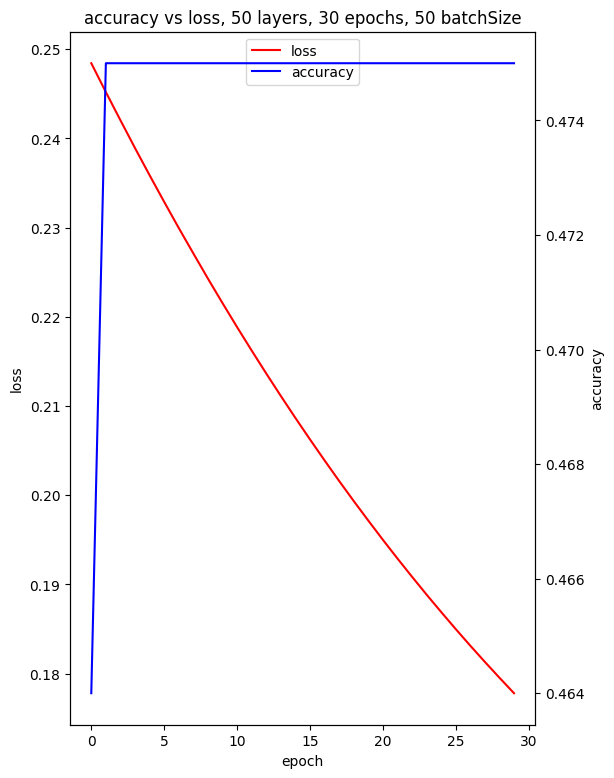

Epoch 1/30
10/10 [==============================] - 2s 61ms/step - loss: 0.2493 - accuracy: 0.4660
Epoch 2/30
10/10 [==============================] - 1s 59ms/step - loss: 0.2476 - accuracy: 0.4750
Epoch 3/30
10/10 [==============================] - 1s 57ms/step - loss: 0.2460 - accuracy: 0.4750
Epoch 4/30
10/10 [==============================] - 1s 61ms/step - loss: 0.2444 - accuracy: 0.4750
Epoch 5/30
10/10 [==============================] - 1s 61ms/step - loss: 0.2428 - accuracy: 0.4750
Epoch 6/30
10/10 [==============================] - 1s 61ms/step - loss: 0.2412 - accuracy: 0.4750
Epoch 7/30
10/10 [==============================] - 1s 58ms/step - loss: 0.2397 - accuracy: 0.4750
Epoch 8/30
10/10 [==============================] - 1s 62ms/step - loss: 0.2381 - accuracy: 0.4750
Epoch 9/30
10/10 [==============================] - 1s 61ms/step - loss: 0.2366 - accuracy: 0.4750
Epoch 10/30
10/10 [==============================] - 1s 58ms/step - loss: 0.2351 - accuracy: 0.4750
Epoch 11/

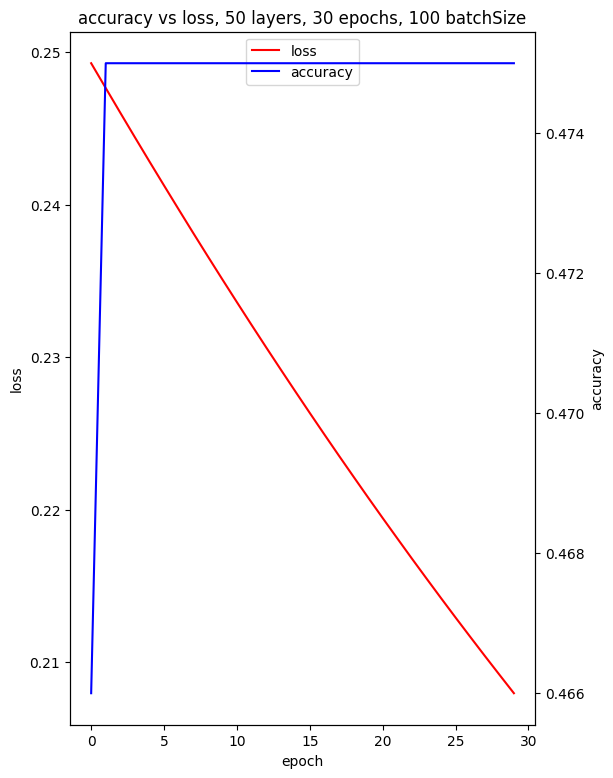

Epoch 1/30
7/7 [==============================] - 2s 62ms/step - loss: 0.2495 - accuracy: 0.4590
Epoch 2/30
7/7 [==============================] - 0s 65ms/step - loss: 0.2484 - accuracy: 0.4750
Epoch 3/30
7/7 [==============================] - 0s 68ms/step - loss: 0.2472 - accuracy: 0.4750
Epoch 4/30
7/7 [==============================] - 0s 67ms/step - loss: 0.2461 - accuracy: 0.4750
Epoch 5/30
7/7 [==============================] - 0s 69ms/step - loss: 0.2450 - accuracy: 0.4750
Epoch 6/30
7/7 [==============================] - 0s 67ms/step - loss: 0.2438 - accuracy: 0.4750
Epoch 7/30
7/7 [==============================] - 0s 64ms/step - loss: 0.2427 - accuracy: 0.4750
Epoch 8/30
7/7 [==============================] - 0s 67ms/step - loss: 0.2416 - accuracy: 0.4750
Epoch 9/30
7/7 [==============================] - 0s 67ms/step - loss: 0.2405 - accuracy: 0.4750
Epoch 10/30
7/7 [==============================] - 0s 70ms/step - loss: 0.2394 - accuracy: 0.4750
Epoch 11/30
7/7 [============

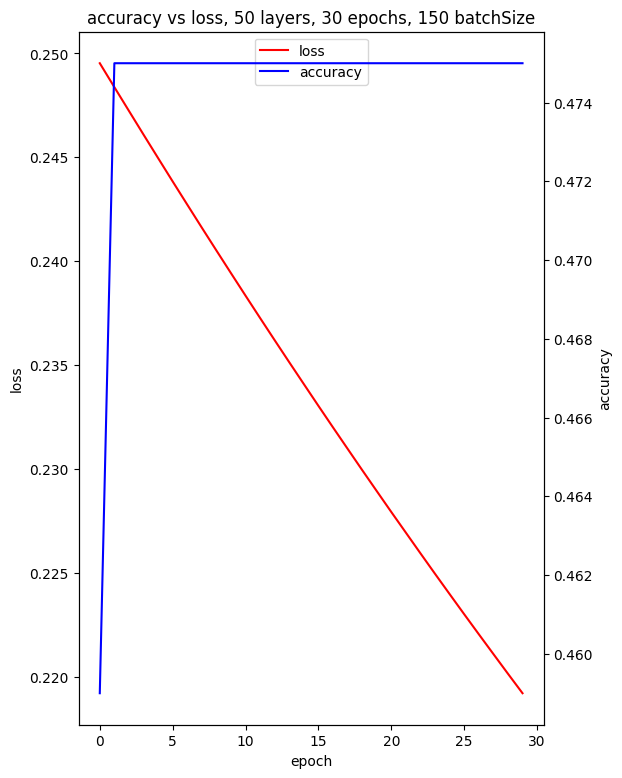

In [28]:
numberOfLayersToTest = [3, 7, 10, 15, 20, 50]
epochsToTest = [10, 20, 30]
batchSizesToTest = [50, 100, 150]
histories, models = trainModels(numberOfLayersToTest, epochsToTest, batchSizesToTest, x_vector, labels)

# running the model on full dataset

In [6]:
full = data.copy() # don't want to change the original data

### creating labels vector

In [7]:
Conditions_one_hot = pd.get_dummies(full.Conditions)
Conditions_one_hot

Clear  Overcast  Partially cloudy  Rain  Rain, Overcast  \
0           0         1                 0     0               0   
1           0         1                 0     0               0   
2           0         1                 0     0               0   
3           0         1                 0     0               0   
4           0         1                 0     0               0   
...       ...       ...               ...   ...             ...   
439913      0         0                 1     0               0   
439914      0         1                 0     0               0   
439915      0         0                 1     0               0   
439916      0         0                 0     0               0   
439917      0         1                 0     0               0   

        Rain, Partially cloudy  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  
...                        ...  
439913                       0  
439914                       0  
439915                       0  
439916                       0  
439917                       0  

[439918 rows x 6 columns]

In [8]:
labels = tf.convert_to_tensor(Conditions_one_hot, dtype = tf.float64)

### fixing date time and weather type objects

In [9]:
full['Date time'] = pd.to_datetime(full['Date time'])
full['Date time'] = full['Date time'].apply(lambda x: x.timestamp())
full['Date time']

0         1.675210e+09
1         1.675213e+09
2         1.675217e+09
3         1.675220e+09
4         1.675224e+09
              ...     
439913    9.597240e+07
439914    9.597600e+07
439915    9.597960e+07
439916    9.598320e+07
439917    9.598680e+07
Name: Date time, Length: 439918, dtype: float64

In [10]:
full['Weather Type'] = full['Weather Type'].str.split(',')
full['Weather Type']

0                               [Thunderstorm]
1                               [Thunderstorm]
2                 [Mist,  Rain,  Thunderstorm]
3                  [Thunderstorm,  Light Rain]
4                        [Rain,  Thunderstorm]
                          ...                 
439913                                  [Rain]
439914          [Snow And Rain Showers,  Rain]
439915                                     NaN
439916                                     NaN
439917    [Snow And Rain Showers,  Light Rain]
Name: Weather Type, Length: 439918, dtype: object

In [13]:
df2 = full['Weather Type'].to_frame()
df2['Weather Type'] = df2['Weather Type'].apply(lambda d: d if isinstance(d, list) else [])
mlb = MultiLabelBinarizer()
df_transformed2 = pd.DataFrame(mlb.fit_transform(df2['Weather Type']), columns=mlb.classes_, index=df2.index)
df_transformed2.columns

Index([' Drizzle', ' Dust storm', ' Fog', ' Freezing Drizzle/Freezing Rain',
       ' Funnel Cloud/Tornado', ' Heavy Drizzle', ' Heavy Drizzle/Rain',
       ' Heavy Freezing Rain', ' Heavy Rain', ' Heavy Rain And Snow',
       ' Heavy Snow', ' Light Drizzle', ' Light Drizzle/Rain',
       ' Light Freezing Rain', ' Light Rain', ' Light Rain And Snow',
       ' Light Snow', ' Lightning Without Thunder', ' Mist',
       ' Precipitation In Vicinity', ' Rain', ' Rain Showers',
       ' Sky Coverage Decreasing', ' Sky Coverage Increasing',
       ' Sky Unchanged', ' Smoke Or Haze', ' Snow', ' Snow Showers',
       ' Squalls', ' Thunderstorm', ' Thunderstorm Without Precipitation',
       'Drizzle', 'Dust storm', 'Fog', 'Funnel Cloud/Tornado', 'Hail Showers',
       'Heavy Drizzle', 'Heavy Drizzle/Rain', 'Heavy Freezing Rain',
       'Heavy Rain', 'Heavy Rain And Snow', 'Heavy Snow', 'Ice',
       'Light Drizzle', 'Light Drizzle/Rain', 'Light Freezing Rain',
       'Light Rain', 'Light Rain A

### creating feature vector

In [14]:
x_vector = pd.concat((full.drop(['Weather Type', 'Conditions'], axis=1),df_transformed2), axis=1)
x_vector

Unnamed: 0     Date time  Minimum Temperature  Maximum Temperature  \
0                0  1.675210e+09                 50.9                 50.9   
1                1  1.675213e+09                 44.0                 44.0   
2                2  1.675217e+09                 44.7                 44.7   
3                3  1.675220e+09                 44.7                 44.7   
4                4  1.675224e+09                 44.7                 44.7   
...            ...           ...                  ...                  ...   
439913         353  9.597240e+07                 46.9                 46.9   
439914         354  9.597600e+07                 35.8                 35.8   
439915         355  9.597960e+07                 35.7                 35.7   
439916         356  9.598320e+07                  NaN                  NaN   
439917         357  9.598680e+07                 36.5                 36.5   

        Temperature  Dew Point  Relative Humidity  Heat Index  Wind Speed  \
0              50.9       49.1              93.53         NaN         7.0   
1              44.0       39.5              84.07         NaN        13.0   
2              44.7       39.9              82.97         NaN        10.1   
3              44.7       39.9              82.95         NaN        14.3   
4              44.7       39.9              82.97         NaN         9.8   
...             ...        ...                ...         ...         ...   
439913         46.9       38.1              71.29         NaN        20.2   
439914         35.8       34.0              93.09         NaN        31.6   
439915         35.7       33.9              93.09         NaN        20.6   
439916          NaN        NaN                NaN         NaN         NaN   
439917         36.5       35.9              97.70         NaN        30.6   

        Wind Gust  ...  Sky Coverage Decreasing  Sky Coverage Increasing  \
0             NaN  ...                        0                        0   
1             NaN  ...                        0                        0   
2             NaN  ...                        0                        0   
3             NaN  ...                        0                        0   
4             NaN  ...                        0                        0   
...           ...  ...                      ...                      ...   
439913        NaN  ...                        0                        0   
439914        NaN  ...                        0                        0   
439915        NaN  ...                        0                        0   
439916        NaN  ...                        0                        0   
439917        NaN  ...                        0                        0   

        Sky Unchanged  Smoke Or Haze  Snow  Snow And Rain Showers  \
0                   0              0     0                      0   
1                   0              0     0                      0   
2                   0              0     0                      0   
3                   0              0     0                      0   
4                   0              0     0                      0   
...               ...            ...   ...                    ...   
439913              0              0     0                      0   
439914              0              0     0                      1   
439915              0              0     0                      0   
439916              0              0     0                      0   
439917              0              0     0                      1   

        Snow Showers  Squalls  Thunderstorm  \
0                  0        0             1   
1                  0        0             1   
2                  0        0             0   
3                  0        0             1   
4                  0        0             0   
...              ...      ...           ...   
439913             0        0             0   
439914             0        

### testing different model configuration
we can see it crashed after 11 configuration.
we also can see that there was no difference between the configurations
so, we didn't try and run it again.

Epoch 1/10
8799/8799 [==============================] - 90s 10ms/step - loss: 0.1165 - accuracy: 0.5074
Epoch 2/10
8799/8799 [==============================] - 89s 10ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 3/10
8799/8799 [==============================] - 87s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 4/10
8799/8799 [==============================] - 88s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 5/10
8799/8799 [==============================] - 99s 11ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 6/10
8799/8799 [==============================] - 91s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/10
8799/8799 [==============================] - 87s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/10
8799/8799 [==============================] - 87s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/10
8799/8799 [==============================] - 88s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/10
8799/8799 [==============================] - 87s 10m

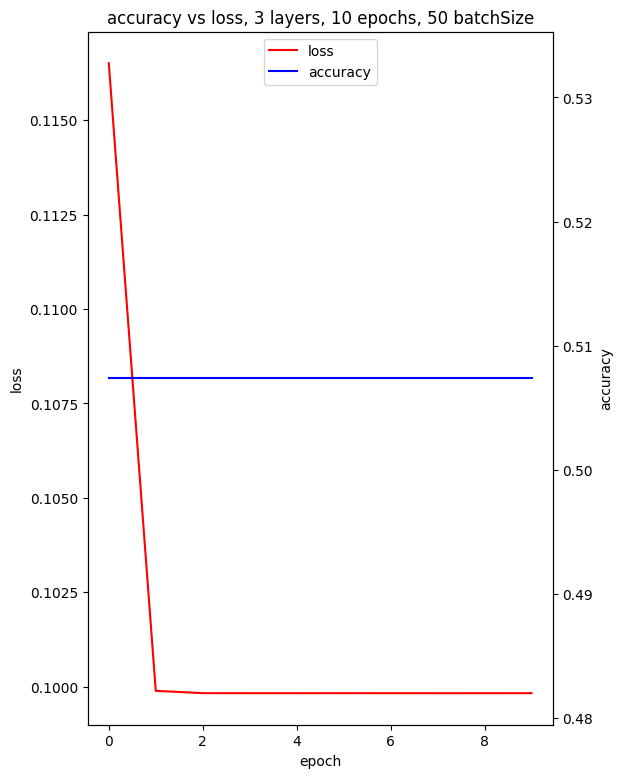

Epoch 1/10
4400/4400 [==============================] - 44s 10ms/step - loss: 0.1319 - accuracy: 0.5073
Epoch 2/10
4400/4400 [==============================] - 44s 10ms/step - loss: 0.1011 - accuracy: 0.5074
Epoch 3/10
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 4/10
4400/4400 [==============================] - 45s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 5/10
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 6/10
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/10
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/10
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/10
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/10
4400/4400 [==============================] - 44s 10m

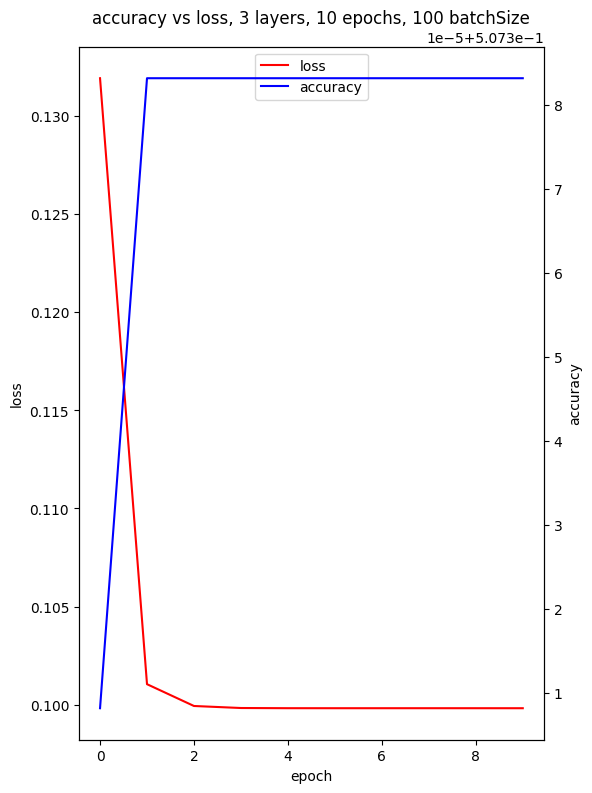

Epoch 1/10
2933/2933 [==============================] - 30s 10ms/step - loss: 0.1451 - accuracy: 0.5074
Epoch 2/10
2933/2933 [==============================] - 30s 10ms/step - loss: 0.1037 - accuracy: 0.5074
Epoch 3/10
2933/2933 [==============================] - 29s 10ms/step - loss: 0.1005 - accuracy: 0.5074
Epoch 4/10
2933/2933 [==============================] - 29s 10ms/step - loss: 0.1000 - accuracy: 0.5074
Epoch 5/10
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 6/10
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/10
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/10
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/10
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/10
2933/2933 [==============================] - 30s 10m

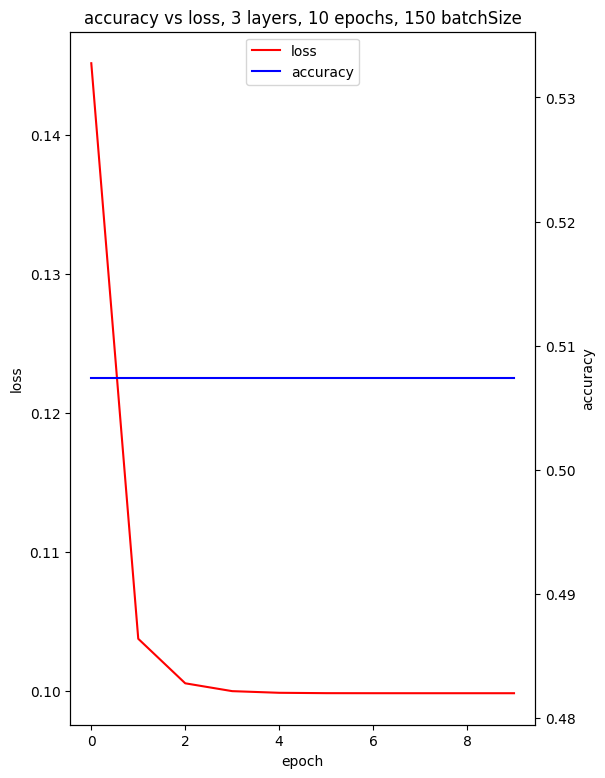

Epoch 1/20
8799/8799 [==============================] - 87s 10ms/step - loss: 0.1165 - accuracy: 0.5072
Epoch 2/20
8799/8799 [==============================] - 86s 10ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 3/20
8799/8799 [==============================] - 86s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 4/20
8799/8799 [==============================] - 87s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 5/20
8799/8799 [==============================] - 86s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 6/20
8799/8799 [==============================] - 86s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/20
8799/8799 [==============================] - 89s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/20
8799/8799 [==============================] - 86s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/20
8799/8799 [==============================] - 86s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/20
8799/8799 [==============================] - 86s 10m

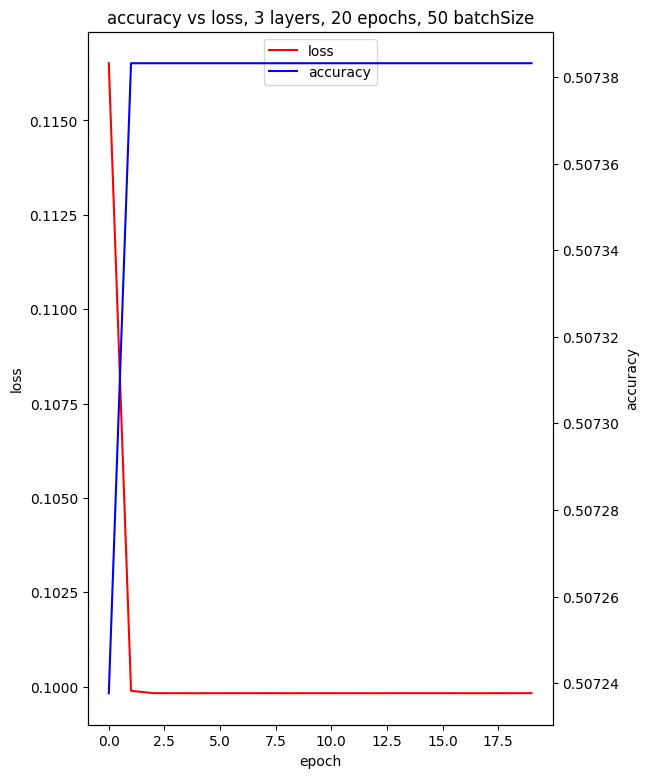

Epoch 1/20
4400/4400 [==============================] - 45s 10ms/step - loss: 0.1319 - accuracy: 0.5074
Epoch 2/20
4400/4400 [==============================] - 44s 10ms/step - loss: 0.1011 - accuracy: 0.5074
Epoch 3/20
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 4/20
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 5/20
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 6/20
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/20
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/20
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/20
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/20
4400/4400 [==============================] - 45s 10m

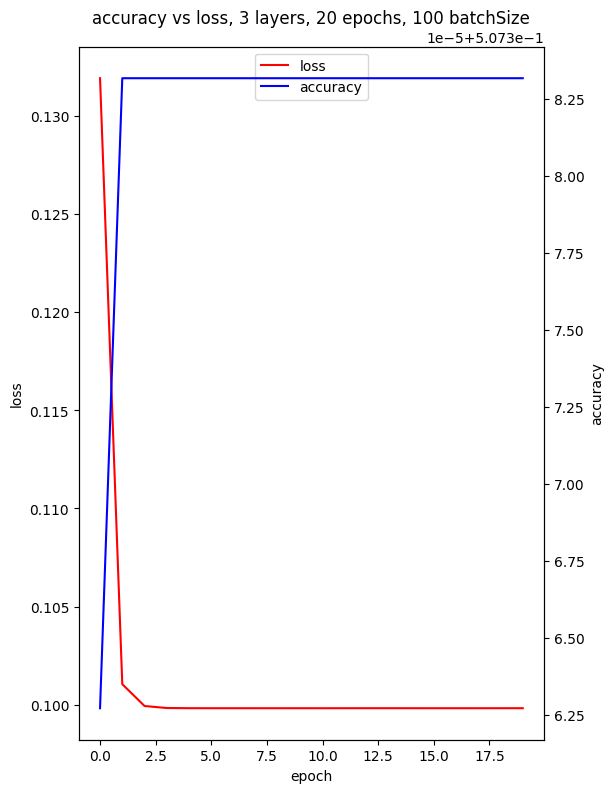

Epoch 1/20
2933/2933 [==============================] - 30s 10ms/step - loss: 0.1451 - accuracy: 0.5074
Epoch 2/20
2933/2933 [==============================] - 29s 10ms/step - loss: 0.1037 - accuracy: 0.5074
Epoch 3/20
2933/2933 [==============================] - 29s 10ms/step - loss: 0.1005 - accuracy: 0.5074
Epoch 4/20
2933/2933 [==============================] - 29s 10ms/step - loss: 0.1000 - accuracy: 0.5074
Epoch 5/20
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 6/20
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/20
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/20
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/20
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/20
2933/2933 [==============================] - 29s 10m

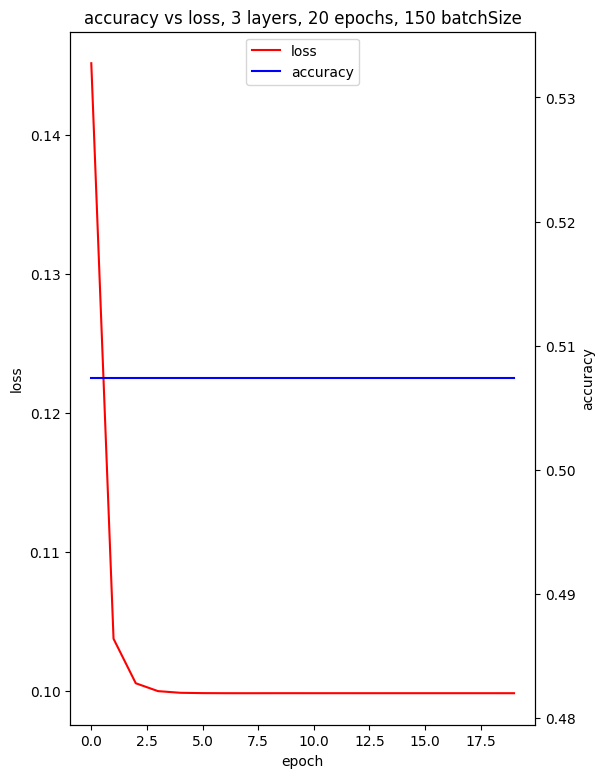

Epoch 1/30
8799/8799 [==============================] - 85s 10ms/step - loss: 0.1165 - accuracy: 0.5074
Epoch 2/30
8799/8799 [==============================] - 84s 10ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 3/30
8799/8799 [==============================] - 85s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 4/30
8799/8799 [==============================] - 85s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 5/30
8799/8799 [==============================] - 86s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 6/30
8799/8799 [==============================] - 85s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/30
8799/8799 [==============================] - 85s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/30
8799/8799 [==============================] - 85s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/30
8799/8799 [==============================] - 85s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/30
8799/8799 [==============================] - 85s 10m

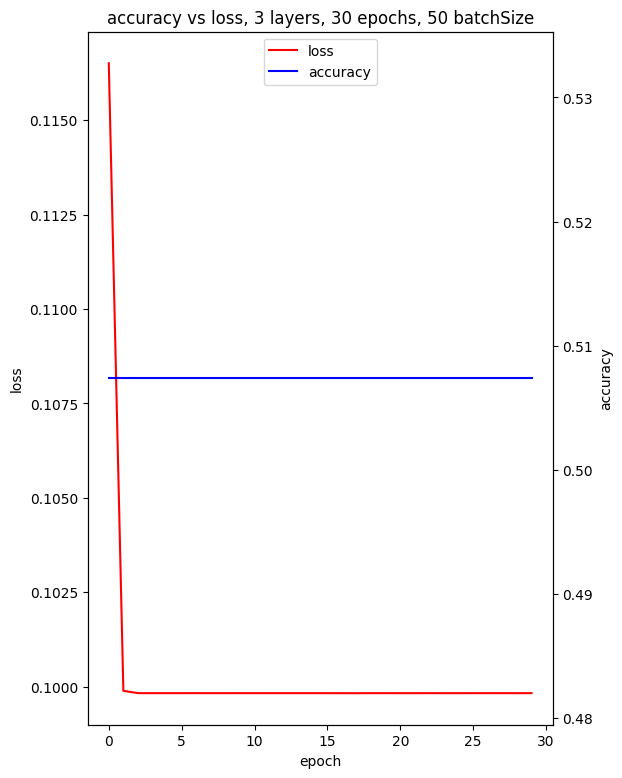

Epoch 1/30
4400/4400 [==============================] - 60s 13ms/step - loss: 0.1319 - accuracy: 0.5074
Epoch 2/30
4400/4400 [==============================] - 45s 10ms/step - loss: 0.1011 - accuracy: 0.5074
Epoch 3/30
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 4/30
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 5/30
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 6/30
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/30
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/30
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/30
4400/4400 [==============================] - 44s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/30
4400/4400 [==============================] - 48s 11m

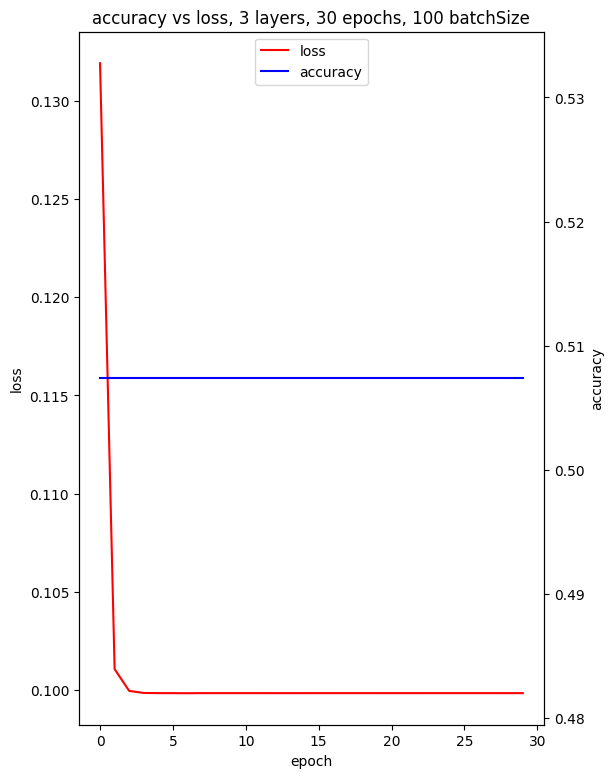

Epoch 1/30
2933/2933 [==============================] - 30s 10ms/step - loss: 0.1451 - accuracy: 0.5074
Epoch 2/30
2933/2933 [==============================] - 29s 10ms/step - loss: 0.1037 - accuracy: 0.5074
Epoch 3/30
2933/2933 [==============================] - 29s 10ms/step - loss: 0.1005 - accuracy: 0.5074
Epoch 4/30
2933/2933 [==============================] - 29s 10ms/step - loss: 0.1000 - accuracy: 0.5074
Epoch 5/30
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 6/30
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/30
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/30
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/30
2933/2933 [==============================] - 29s 10ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/30
2933/2933 [==============================] - 29s 10m

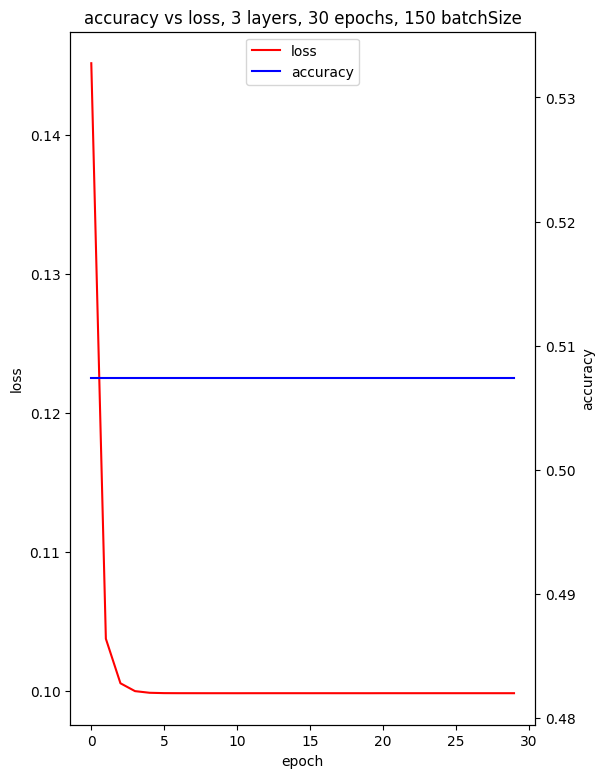

Epoch 1/10
8799/8799 [==============================] - 111s 12ms/step - loss: 0.1165 - accuracy: 0.5074
Epoch 2/10
8799/8799 [==============================] - 109s 12ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 3/10
8799/8799 [==============================] - 109s 12ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 4/10
8799/8799 [==============================] - 109s 12ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 5/10
8799/8799 [==============================] - 110s 12ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 6/10
8799/8799 [==============================] - 111s 13ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/10
8799/8799 [==============================] - 110s 13ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/10
8799/8799 [==============================] - 110s 12ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/10
8799/8799 [==============================] - 110s 13ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/10
8799/8799 [==============================] 

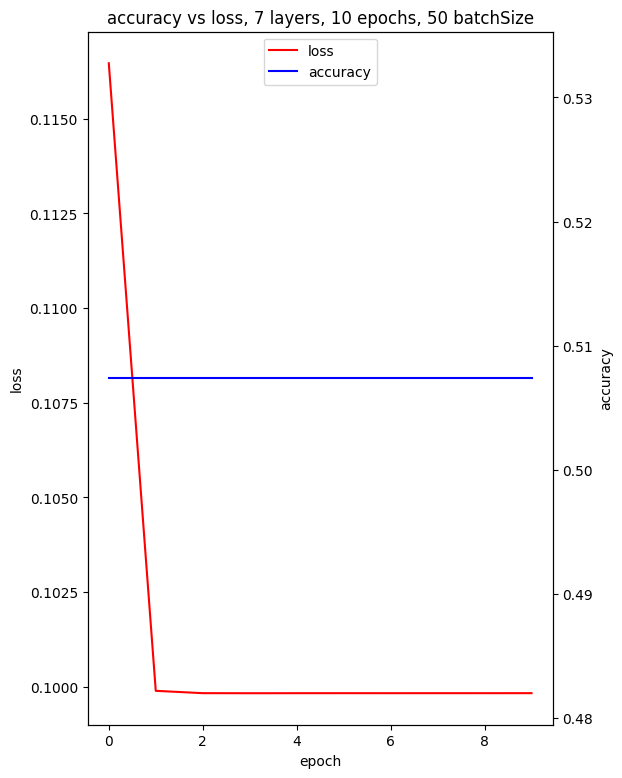

Epoch 1/10
4400/4400 [==============================] - 61s 14ms/step - loss: 0.1319 - accuracy: 0.5074
Epoch 2/10
4400/4400 [==============================] - 58s 13ms/step - loss: 0.1010 - accuracy: 0.5074
Epoch 3/10
4400/4400 [==============================] - 58s 13ms/step - loss: 0.0999 - accuracy: 0.5074
Epoch 4/10
4400/4400 [==============================] - 58s 13ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 5/10
4400/4400 [==============================] - 58s 13ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 6/10
4400/4400 [==============================] - 58s 13ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 7/10
4400/4400 [==============================] - 58s 13ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 8/10
4400/4400 [==============================] - 59s 14ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 9/10
4400/4400 [==============================] - 58s 13ms/step - loss: 0.0998 - accuracy: 0.5074
Epoch 10/10
4400/4400 [==============================] - 58s 13m

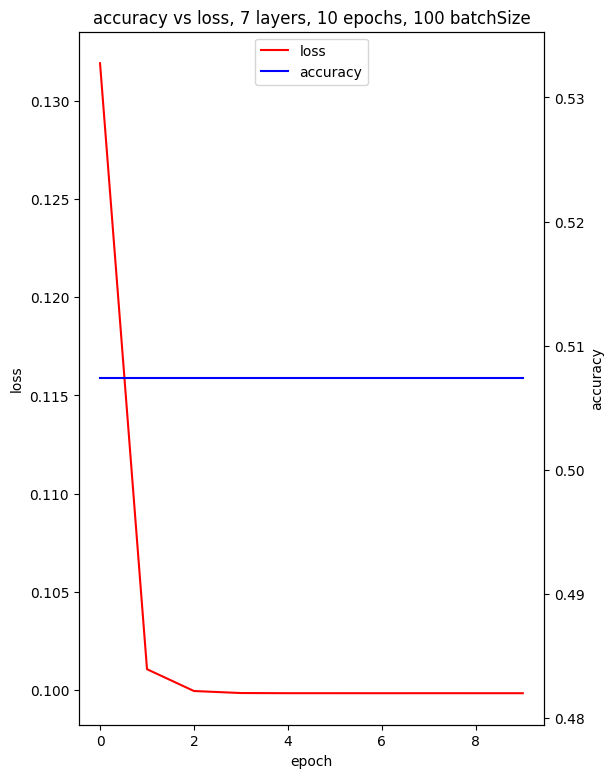

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [36]:
numberOfLayersToTest = [3, 7, 10, 15, 20, 50]
epochsToTest = [10, 20, 30]
batchSizesToTest = [50, 100, 150]
histories, models = trainModels(numberOfLayersToTest, epochsToTest, batchSizesToTest, x_vector, labels)

 # running chosen model:

In [60]:
model = generateModelPerLayerNumber(3,x_vector.shape[1])
weather = model.fit(x_vector, labels, validation_split=0.2, epochs=10, batch_size=50)

Epoch 1/10
7039/7039 [==============================] - 76s 11ms/step - loss: 0.1217 - accuracy: 0.4869 - val_loss: 0.0959 - val_accuracy: 0.5894
Epoch 2/10
7039/7039 [==============================] - 78s 11ms/step - loss: 0.1013 - accuracy: 0.4869 - val_loss: 0.0953 - val_accuracy: 0.5894
Epoch 3/10
7039/7039 [==============================] - 86s 12ms/step - loss: 0.1011 - accuracy: 0.4869 - val_loss: 0.0952 - val_accuracy: 0.5894
Epoch 4/10
7039/7039 [==============================] - 78s 11ms/step - loss: 0.1011 - accuracy: 0.4869 - val_loss: 0.0951 - val_accuracy: 0.5894
Epoch 5/10
7039/7039 [==============================] - 79s 11ms/step - loss: 0.1011 - accuracy: 0.4869 - val_loss: 0.0950 - val_accuracy: 0.5894
Epoch 6/10
7039/7039 [==============================] - 78s 11ms/step - loss: 0.1011 - accuracy: 0.4869 - val_loss: 0.0953 - val_accuracy: 0.5894
Epoch 7/10
7039/7039 [==============================] - 77s 11ms/step - loss: 0.1011 - accuracy: 0.4869 - val_loss: 0.0954 -

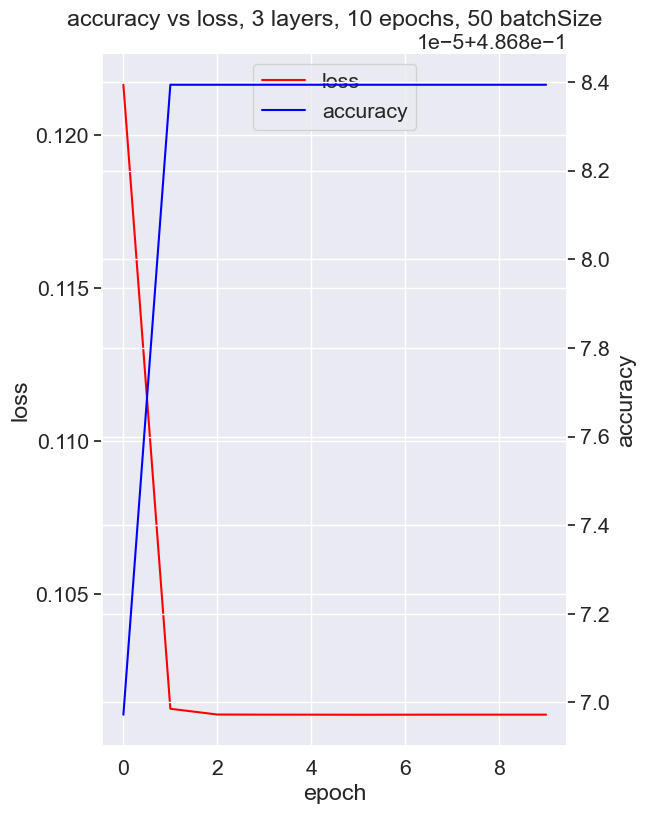

In [62]:
testModel(weather.history, f'accuracy vs loss, 3 layers, 10 epochs, 50 batchSize')

In [63]:
predictedTestLabels = model.predict(x_vector)
rounded_predicted = np.argmax(predictedTestLabels, axis = 1)

13748/13748 [==============================] - 48s 3ms/step


In [65]:
rounded_labels=np.argmax(labels, axis=1)

In [66]:
confusionMatrix = confusion_matrix(y_true = rounded_labels, y_pred = rounded_predicted)

In [68]:
confusionMatrix

array([[223207,      0,      0,      0,      0,      0],
       [ 57384,      0,      0,      0,      0,      0],
       [155834,      0,      0,      0,      0,      0],
       [   135,      0,      0,      0,      0,      0],
       [  2319,      0,      0,      0,      0,      0],
       [  1039,      0,      0,      0,      0,      0]], dtype=int64)

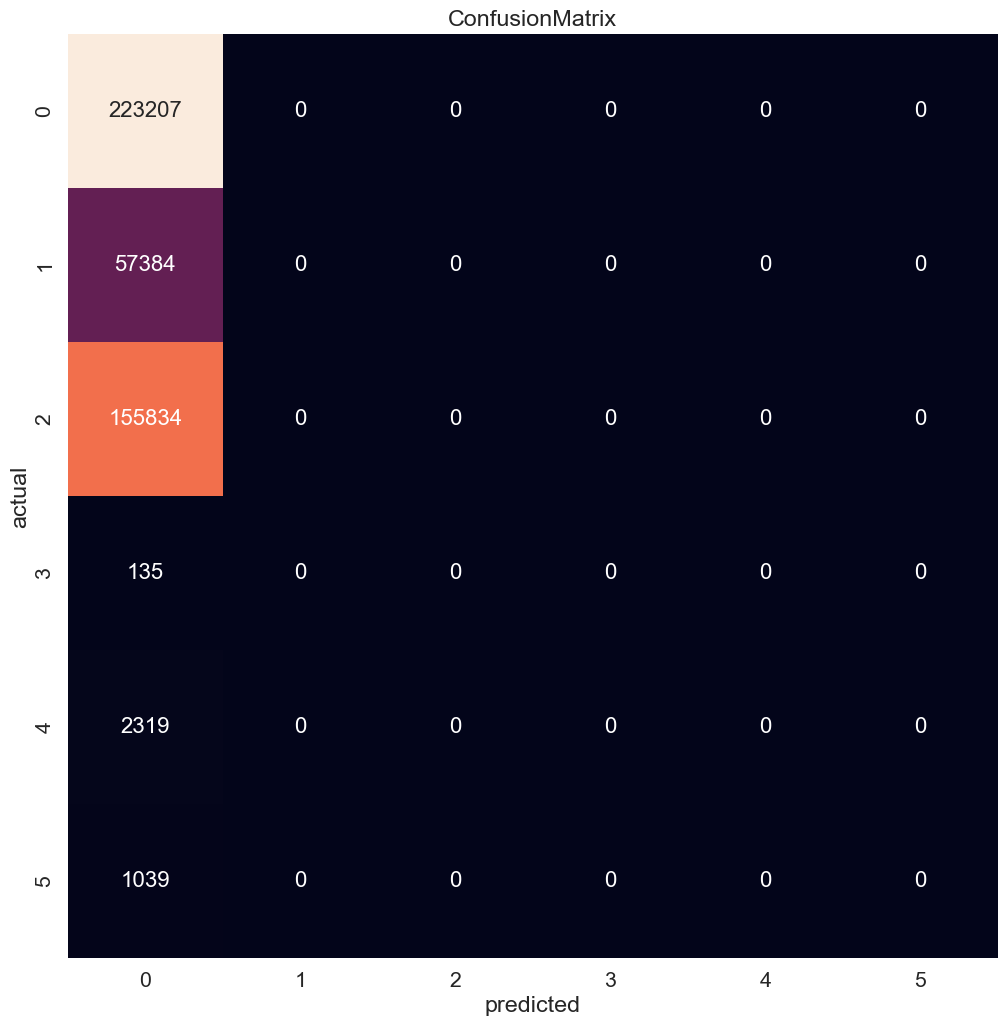

In [70]:
plotConfusionMatrix(confusionMatrixQuestionOne)

In [71]:
np.unique(predictedTestLabels)

array([2.9229213e-04, 2.6807070e-03, 5.5717286e-03, 1.3452570e-01,
       3.6721340e-01, 4.6034932e-01], dtype=float32)

## running it againg with dived test and train data

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x_vector, Conditions_one_hot, test_size=0.2, random_state=42)

In [73]:
model = generateModelPerLayerNumber(3,x_vector.shape[1])
weather = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=50)

Epoch 1/10
5631/5631 [==============================] - 62s 11ms/step - loss: 0.1254 - accuracy: 0.5073 - val_loss: 0.1016 - val_accuracy: 0.5049
Epoch 2/10
5631/5631 [==============================] - 62s 11ms/step - loss: 0.1003 - accuracy: 0.5073 - val_loss: 0.1000 - val_accuracy: 0.5049
Epoch 3/10
5631/5631 [==============================] - 64s 11ms/step - loss: 0.0998 - accuracy: 0.5073 - val_loss: 0.0999 - val_accuracy: 0.5049
Epoch 4/10
5631/5631 [==============================] - 63s 11ms/step - loss: 0.0998 - accuracy: 0.5073 - val_loss: 0.0999 - val_accuracy: 0.5049
Epoch 5/10
5631/5631 [==============================] - 62s 11ms/step - loss: 0.0998 - accuracy: 0.5073 - val_loss: 0.0999 - val_accuracy: 0.5049
Epoch 6/10
5631/5631 [==============================] - 62s 11ms/step - loss: 0.0998 - accuracy: 0.5073 - val_loss: 0.0999 - val_accuracy: 0.5049
Epoch 7/10
5631/5631 [==============================] - 62s 11ms/step - loss: 0.0998 - accuracy: 0.5073 - val_loss: 0.0999 -

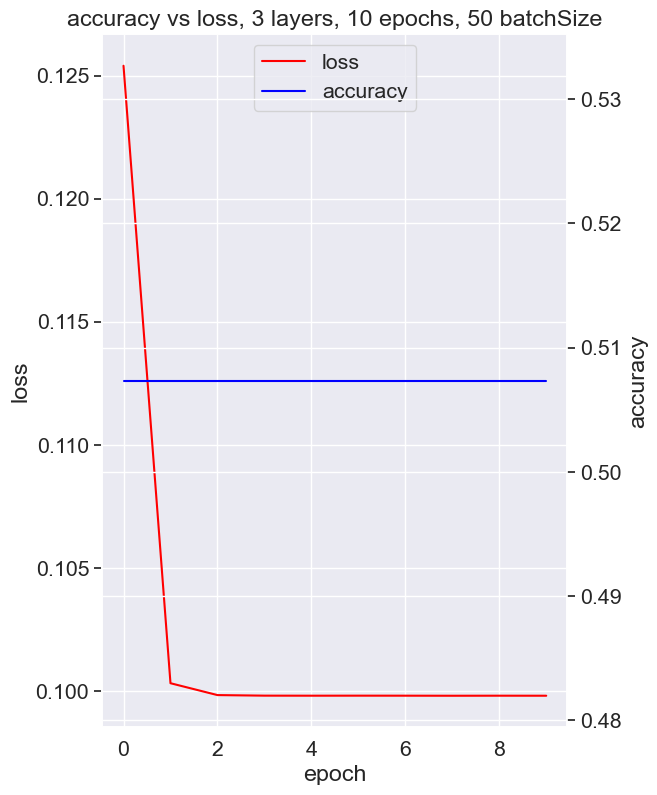

In [74]:
testModel(weather.history, f'accuracy vs loss, 3 layers, 10 epochs, 50 batchSize')

In [75]:
predictedTestLabels = model.predict(X_test)
rounded_predicted = np.argmax(predictedTestLabels, axis = 1)

2750/2750 [==============================] - 10s 4ms/step


In [86]:
predictedTestLabels

array([[4.7359911e-01, 1.3181627e-01, 3.4573650e-01, 3.0972643e-04,
        5.1924433e-03, 2.3161175e-03],
       [4.7359911e-01, 1.3181627e-01, 3.4573650e-01, 3.0972643e-04,
        5.1924433e-03, 2.3161175e-03],
       [4.7359911e-01, 1.3181627e-01, 3.4573650e-01, 3.0972643e-04,
        5.1924433e-03, 2.3161175e-03],
       ...,
       [4.7359911e-01, 1.3181627e-01, 3.4573650e-01, 3.0972643e-04,
        5.1924433e-03, 2.3161175e-03],
       [4.7359911e-01, 1.3181627e-01, 3.4573650e-01, 3.0972643e-04,
        5.1924433e-03, 2.3161175e-03],
       [4.7359911e-01, 1.3181627e-01, 3.4573650e-01, 3.0972643e-04,
        5.1924433e-03, 2.3161175e-03]], dtype=float32)

In [77]:
y_test

Clear  Overcast  Partially cloudy  Rain  Rain, Overcast  \
50568       0         0                 1     0               0   
5948        0         1                 0     0               0   
225373      0         0                 1     0               0   
314415      0         0                 0     0               0   
24616       0         0                 1     0               0   
...       ...       ...               ...   ...             ...   
367643      1         0                 0     0               0   
66272       0         1                 0     0               0   
129293      1         0                 0     0               0   
369457      0         0                 1     0               0   
370412      0         0                 1     0               0   

        Rain, Partially cloudy  
50568                        0  
5948                         0  
225373                       0  
314415                       0  
24616                        0  
...                        ...  
367643                       0  
66272                        0  
129293                       0  
369457                       0  
370412                       0  

[87984 rows x 6 columns]

In [81]:
rounded_labels=np.argmax(np.array(y_test), axis=1)

In [83]:
confusionMatrix = confusion_matrix(y_true = rounded_labels, y_pred = rounded_predicted)
confusionMatrix

array([[44832,     0,     0,     0,     0,     0],
       [11603,     0,     0,     0,     0,     0],
       [30889,     0,     0,     0,     0,     0],
       [   28,     0,     0,     0,     0,     0],
       [  432,     0,     0,     0,     0,     0],
       [  200,     0,     0,     0,     0,     0]], dtype=int64)

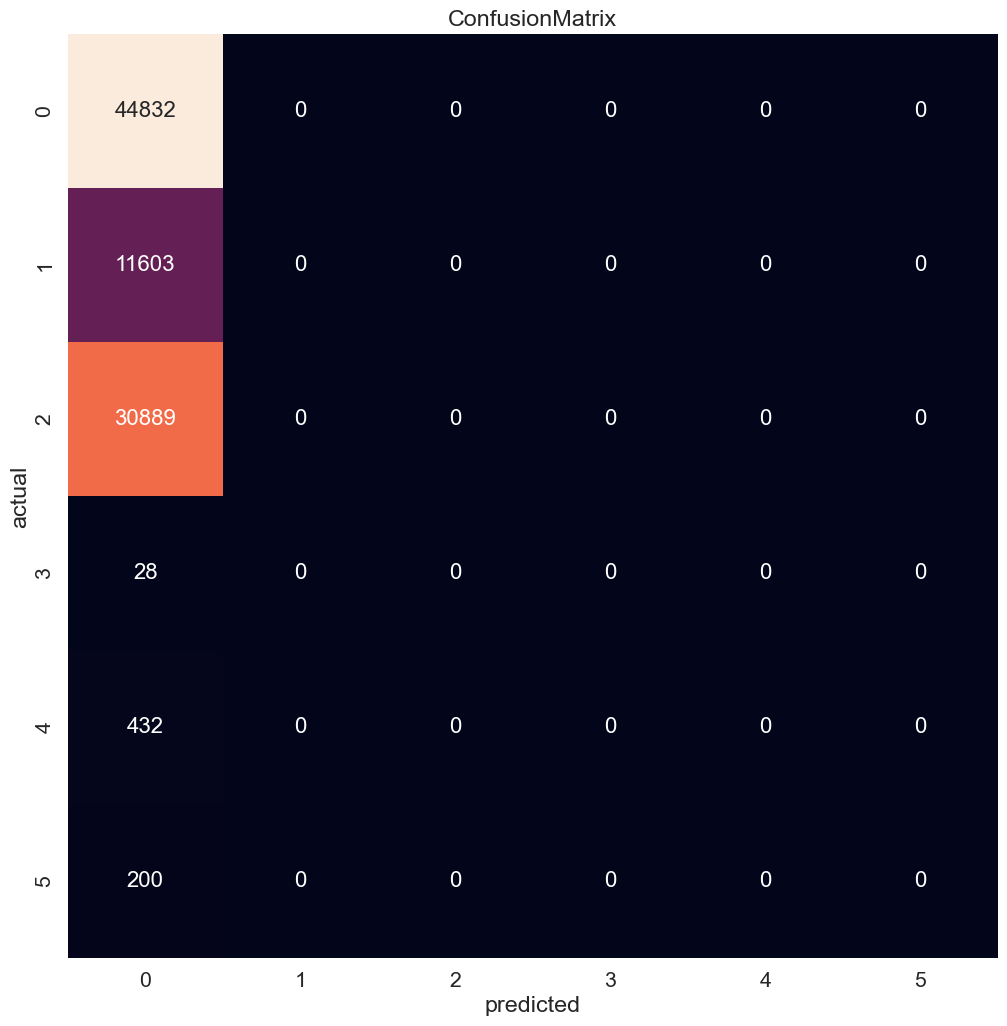

In [85]:
plotConfusionMatrix(confusionMatrix)